In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from focal_loss import BinaryFocalLoss
from keras import backend as K 
from shapely import wkt

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *
from IAdeforestation.tools import *
from IAdeforestation.spatial_cross_val import * 

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6227001648475912019
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7783953216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1124966849597055993
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'transfer_learning')
SAVED_DATASET_PATH = "datasets"
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))
#IMAGES_DIR = 'D:\\fall_images' # For 64x64 images
#IMAGES_DIR = 'images'
#IMAGES_DIR = 'D:\img32' # For 32x32 images

In [8]:
def compute_score(geo_val, model):
    
    test_generator = generator(geo_val['path'].to_numpy(), 
                        geo_val['label'].to_numpy(), 
                        eurosat_params['mean'], 
                        eurosat_params['std'], 
                        batch_size=len(geo_val))
    
    model.evaluate(test_generator,steps=1)
    Y_true = []
    Y_pred = []
    for i in range (0,1):
        X, Y = next(test_generator)
        Y_pred.extend(np.where(model.predict(X) > 0.5, 1, 0))

        Y_true.extend(Y.tolist())

    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    cm = confusion_matrix(Y_true, Y_pred)
    print(cm)
    
    print(classification_report(Y_true, Y_pred))
    print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Load base model

In [4]:
source_model = load_model("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5", compile=False)
source_model.trainable = False

In [5]:
#source_model = change_model(source_model, new_input_shape=(None, 32,32,13),custom_objects={'LeakyReLU':LeakyReLU})

In [6]:
source_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [7]:
def create_model():
    # Add new layer to pre-trained network
    flat1 = Flatten()(source_model.layers[-3].output)
    dropout_flatten = Dropout(0.5)(flat1)

    dense256 = Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
    dropout256 = Dropout(0.5)(dense256)

    dense32 = Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout256)
    dropout32 = Dropout(0.5)(dense32)

    output = Dense(1, activation='sigmoid')(dropout32)

    return Model(inputs=source_model.input, outputs=output)

# Coffee vs other
## Model creation

In [23]:
model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 38, 38, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

## Load Data

In [15]:
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
np.random.shuffle(path1)
class1 = [0]*len(path1)

In [16]:
other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
random.shuffle(path2)
class2 = [1]*len(path2)

In [17]:
file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)
path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.20)

In [101]:
# Params
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
EPOCH = 100
RUN_NAME = 'test'
LOGS_PATH = 'logs'

In [102]:
train_generator = generator(path_train, 
                            y_train, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE, 
                            is_data_augmentation=True)

test_generator = generator(path_test, 
                           y_test, 
                           eurosat_params['mean'], 
                           eurosat_params['std'], 
                           batch_size=BATCH_SIZE, 
                           is_data_augmentation=False)

In [103]:
earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
#tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

In [ ]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper])

Epoch 1/100
 77/147 [==============>...............] - ETA: 9s - loss: 2.4839 - accuracy: 0.6449

In [28]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))

model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.npy'),history.history)

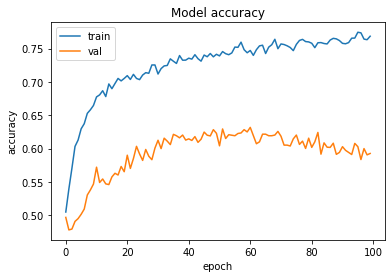

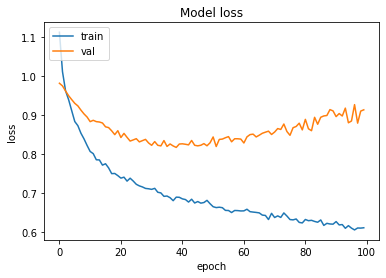

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model evaluation

In [17]:
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
model.evaluate_generator(test_generator,30)

[0.6172418137391408, 0.7651042]

In [32]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(final_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [33]:
cm = confusion_matrix(Y_true, Y_pred)

In [34]:
cm

array([[944,  43],
       [473, 460]], dtype=int64)

In [35]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.67      0.96      0.79       987
           1       0.91      0.49      0.64       933

    accuracy                           0.73      1920
   macro avg       0.79      0.72      0.71      1920
weighted avg       0.79      0.73      0.72      1920

F1-Score : 0.6406685236768802


## Spatial Cross val

In [8]:
train_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold_32', 'train_data_32.csv')))
train_data['geometry'] = train_data['geometry'].apply(wkt.loads)

In [9]:
nb_0 = len(train_data[train_data['label']==0])
nb_1 = len(train_data[train_data['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [10]:
nb_labels = train_data['label'].value_counts().to_dict()
prop0 = nb_labels[0]/(nb_labels[0]+nb_labels[1])
prop1 = nb_labels[1]/(nb_labels[0]+nb_labels[1])

print(prop0)
print(prop1)

0.30724070450097846
0.6927592954990215


In [11]:
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))

In [17]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'final_spacv_10FOLD_coffee_32_1'

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

results = []

Fold 1 Number coffee - train : 769
Fold 1 Number no-coffee - train : 1958
Fold 1 Number coffee - val : 173
Fold 1 Number no-coffee - val : 166
Training for fold 1
-----
Epoch 1/100
126/126 [==============================] - 24s 137ms/step - loss: 0.9649 - accuracy: 0.5767 - precision: 0.7382 - recall: 0.6389 - f1_score_keras: 0.6829 - val_loss: 0.9269 - val_accuracy: 0.6687 - val_precision: 0.6270 - val_recall: 0.8193 - val_f1_score_keras: 0.7089
Epoch 2/100
126/126 [==============================] - 15s 118ms/step - loss: 0.9179 - accuracy: 0.6224 - precision: 0.7737 - recall: 0.6778 - f1_score_keras: 0.7208 - val_loss: 0.8923 - val_accuracy: 0.7177 - val_precision: 0.6628 - val_recall: 0.7846 - val_f1_score_keras: 0.7160
Epoch 3/100
126/126 [==============================] - 15s 119ms/step - loss: 0.9016 - accuracy: 0.6313 - precision: 0.7746 - recall: 0.6848 - f1_score_keras: 0.7252 - val_loss: 0.8812 - val_accuracy: 0.6823 - val_precision: 0.7271 - val_recall: 0.6105 - val_f1_score

Epoch 58/100
126/126 [==============================] - 15s 118ms/step - loss: 0.4863 - accuracy: 0.8336 - precision: 0.9367 - recall: 0.8255 - f1_score_keras: 0.8764 - val_loss: 0.7803 - val_accuracy: 0.6906 - val_precision: 0.7947 - val_recall: 0.5053 - val_f1_score_keras: 0.6136
Epoch 59/100
126/126 [==============================] - 15s 119ms/step - loss: 0.4745 - accuracy: 0.8335 - precision: 0.9360 - recall: 0.8246 - f1_score_keras: 0.8766 - val_loss: 0.7846 - val_accuracy: 0.6823 - val_precision: 0.8052 - val_recall: 0.4594 - val_f1_score_keras: 0.5828
Epoch 60/100
126/126 [==============================] - 15s 118ms/step - loss: 0.4875 - accuracy: 0.8286 - precision: 0.9360 - recall: 0.8199 - f1_score_keras: 0.8729 - val_loss: 0.7958 - val_accuracy: 0.6906 - val_precision: 0.7879 - val_recall: 0.5000 - val_f1_score_keras: 0.6083
Epoch 61/100
126/126 [==============================] - 15s 119ms/step - loss: 0.4794 - accuracy: 0.8399 - precision: 0.9493 - recall: 0.8185 - f1_scor

Epoch 87/100
126/126 [==============================] - 15s 118ms/step - loss: 0.4514 - accuracy: 0.8421 - precision: 0.9435 - recall: 0.8315 - f1_score_keras: 0.8832 - val_loss: 0.7341 - val_accuracy: 0.7208 - val_precision: 0.7898 - val_recall: 0.5308 - val_f1_score_keras: 0.6331
Epoch 88/100
126/126 [==============================] - 15s 119ms/step - loss: 0.4616 - accuracy: 0.8450 - precision: 0.9438 - recall: 0.8310 - f1_score_keras: 0.8825 - val_loss: 0.7526 - val_accuracy: 0.7156 - val_precision: 0.8182 - val_recall: 0.4770 - val_f1_score_keras: 0.5999
Epoch 89/100
126/126 [==============================] - 15s 119ms/step - loss: 0.4446 - accuracy: 0.8503 - precision: 0.9488 - recall: 0.8351 - f1_score_keras: 0.8878 - val_loss: 0.7829 - val_accuracy: 0.6896 - val_precision: 0.8053 - val_recall: 0.5052 - val_f1_score_keras: 0.6181
Epoch 90/100
126/126 [==============================] - 15s 120ms/step - loss: 0.4422 - accuracy: 0.8502 - precision: 0.9493 - recall: 0.8352 - f1_scor

Epoch 13/100
123/123 [==============================] - 15s 120ms/step - loss: 0.7093 - accuracy: 0.7502 - precision: 0.8745 - recall: 0.7593 - f1_score_keras: 0.8112 - val_loss: 0.8156 - val_accuracy: 0.6573 - val_precision: 0.6705 - val_recall: 0.6877 - val_f1_score_keras: 0.6779
Epoch 14/100
123/123 [==============================] - 15s 119ms/step - loss: 0.6855 - accuracy: 0.7744 - precision: 0.8897 - recall: 0.7796 - f1_score_keras: 0.8296 - val_loss: 0.8145 - val_accuracy: 0.6500 - val_precision: 0.6362 - val_recall: 0.6765 - val_f1_score_keras: 0.6509
Epoch 15/100
123/123 [==============================] - 15s 119ms/step - loss: 0.6916 - accuracy: 0.7523 - precision: 0.8864 - recall: 0.7523 - f1_score_keras: 0.8126 - val_loss: 0.7882 - val_accuracy: 0.6781 - val_precision: 0.6905 - val_recall: 0.6946 - val_f1_score_keras: 0.6905
Epoch 16/100
123/123 [==============================] - 14s 118ms/step - loss: 0.6716 - accuracy: 0.7806 - precision: 0.9039 - recall: 0.7764 - f1_scor

Epoch 42/100
123/123 [==============================] - 15s 119ms/step - loss: 0.5140 - accuracy: 0.8299 - precision: 0.9392 - recall: 0.8205 - f1_score_keras: 0.8748 - val_loss: 0.6708 - val_accuracy: 0.7083 - val_precision: 0.6631 - val_recall: 0.8760 - val_f1_score_keras: 0.7536
Epoch 43/100
123/123 [==============================] - 15s 120ms/step - loss: 0.5273 - accuracy: 0.8152 - precision: 0.9199 - recall: 0.8155 - f1_score_keras: 0.8631 - val_loss: 0.6583 - val_accuracy: 0.7406 - val_precision: 0.6934 - val_recall: 0.9000 - val_f1_score_keras: 0.7814
Epoch 44/100
123/123 [==============================] - 15s 119ms/step - loss: 0.5255 - accuracy: 0.8227 - precision: 0.9289 - recall: 0.8179 - f1_score_keras: 0.8691 - val_loss: 0.6527 - val_accuracy: 0.7177 - val_precision: 0.6967 - val_recall: 0.8481 - val_f1_score_keras: 0.7637
Epoch 45/100
123/123 [==============================] - 15s 120ms/step - loss: 0.5072 - accuracy: 0.8297 - precision: 0.9362 - recall: 0.8224 - f1_scor

Epoch 71/100
123/123 [==============================] - 15s 119ms/step - loss: 0.4705 - accuracy: 0.8428 - precision: 0.9381 - recall: 0.8382 - f1_score_keras: 0.8839 - val_loss: 0.6095 - val_accuracy: 0.7396 - val_precision: 0.6855 - val_recall: 0.9108 - val_f1_score_keras: 0.7804
Epoch 72/100
123/123 [==============================] - 15s 120ms/step - loss: 0.4831 - accuracy: 0.8441 - precision: 0.9337 - recall: 0.8377 - f1_score_keras: 0.8820 - val_loss: 0.6094 - val_accuracy: 0.7385 - val_precision: 0.6865 - val_recall: 0.8841 - val_f1_score_keras: 0.7715
Epoch 73/100
123/123 [==============================] - 14s 118ms/step - loss: 0.4720 - accuracy: 0.8419 - precision: 0.9292 - recall: 0.8413 - f1_score_keras: 0.8818 - val_loss: 0.6066 - val_accuracy: 0.7323 - val_precision: 0.6794 - val_recall: 0.9022 - val_f1_score_keras: 0.7728
Epoch 74/100
123/123 [==============================] - 14s 118ms/step - loss: 0.4776 - accuracy: 0.8407 - precision: 0.9337 - recall: 0.8378 - f1_scor

Epoch 100/100
4/4 [==============================] - 0s 126ms/step - loss: 0.6043 - accuracy: 0.7422 - precision: 0.6901 - recall: 0.9008 - f1_score_keras: 0.7793
Fold 2 loss : 0.6042938232421875
Fold 2 accuracy : 0.7421875
Fold 2 F1-score : 0.7792856693267822
1/1 [==============================] - 0s 74ms/step - loss: 0.6140 - accuracy: 0.7258 - precision: 0.6692 - recall: 0.9128 - f1_score_keras: 0.7722
[[100  88]
 [ 19 176]]
              precision    recall  f1-score   support

           0       0.84      0.53      0.65       188
           1       0.67      0.90      0.77       195

    accuracy                           0.72       383
   macro avg       0.75      0.72      0.71       383
weighted avg       0.75      0.72      0.71       383

F1-Score : 0.7668845315904139


Fold 3 Number coffee - train : 723
Fold 3 Number no-coffee - train : 1663
Fold 3 Number coffee - val : 219
Fold 3 Number no-coffee - val : 461
Training for fold 3
-----
Epoch 1/100
111/111 [===================

Epoch 26/100
111/111 [==============================] - 15s 134ms/step - loss: 0.6329 - accuracy: 0.7812 - precision: 0.9024 - recall: 0.7660 - f1_score_keras: 0.8279 - val_loss: 0.6724 - val_accuracy: 0.7016 - val_precision: 0.9259 - val_recall: 0.6068 - val_f1_score_keras: 0.7323
Epoch 27/100
111/111 [==============================] - 15s 132ms/step - loss: 0.6142 - accuracy: 0.7887 - precision: 0.9057 - recall: 0.7789 - f1_score_keras: 0.8355 - val_loss: 0.6724 - val_accuracy: 0.7026 - val_precision: 0.9211 - val_recall: 0.6042 - val_f1_score_keras: 0.7266
Epoch 28/100
111/111 [==============================] - 15s 134ms/step - loss: 0.6031 - accuracy: 0.7970 - precision: 0.9179 - recall: 0.7787 - f1_score_keras: 0.8401 - val_loss: 0.6720 - val_accuracy: 0.7151 - val_precision: 0.9345 - val_recall: 0.6194 - val_f1_score_keras: 0.7403
Epoch 29/100
111/111 [==============================] - 15s 135ms/step - loss: 0.5995 - accuracy: 0.7980 - precision: 0.9034 - recall: 0.7916 - f1_scor

Epoch 55/100
111/111 [==============================] - 15s 135ms/step - loss: 0.4978 - accuracy: 0.8314 - precision: 0.9286 - recall: 0.8217 - f1_score_keras: 0.8704 - val_loss: 0.7036 - val_accuracy: 0.7125 - val_precision: 0.9384 - val_recall: 0.6227 - val_f1_score_keras: 0.7443
Epoch 56/100
111/111 [==============================] - 15s 136ms/step - loss: 0.5047 - accuracy: 0.8210 - precision: 0.9281 - recall: 0.8019 - f1_score_keras: 0.8587 - val_loss: 0.6823 - val_accuracy: 0.7203 - val_precision: 0.9369 - val_recall: 0.6241 - val_f1_score_keras: 0.7462
Epoch 57/100
111/111 [==============================] - 15s 134ms/step - loss: 0.4928 - accuracy: 0.8319 - precision: 0.9296 - recall: 0.8187 - f1_score_keras: 0.8694 - val_loss: 0.6832 - val_accuracy: 0.7172 - val_precision: 0.9408 - val_recall: 0.6221 - val_f1_score_keras: 0.7469
Epoch 58/100
111/111 [==============================] - 15s 135ms/step - loss: 0.5013 - accuracy: 0.8332 - precision: 0.9266 - recall: 0.8228 - f1_scor

Epoch 84/100
111/111 [==============================] - 15s 135ms/step - loss: 0.4479 - accuracy: 0.8563 - precision: 0.9385 - recall: 0.8459 - f1_score_keras: 0.8891 - val_loss: 0.6905 - val_accuracy: 0.7297 - val_precision: 0.9310 - val_recall: 0.6466 - val_f1_score_keras: 0.7614
Epoch 85/100
111/111 [==============================] - 15s 134ms/step - loss: 0.4523 - accuracy: 0.8534 - precision: 0.9444 - recall: 0.8382 - f1_score_keras: 0.8871 - val_loss: 0.6958 - val_accuracy: 0.7292 - val_precision: 0.9490 - val_recall: 0.6321 - val_f1_score_keras: 0.7566
Epoch 86/100
111/111 [==============================] - 15s 134ms/step - loss: 0.4530 - accuracy: 0.8512 - precision: 0.9433 - recall: 0.8370 - f1_score_keras: 0.8865 - val_loss: 0.7315 - val_accuracy: 0.7156 - val_precision: 0.9291 - val_recall: 0.6351 - val_f1_score_keras: 0.7532
Epoch 87/100
111/111 [==============================] - 15s 135ms/step - loss: 0.4745 - accuracy: 0.8432 - precision: 0.9360 - recall: 0.8334 - f1_scor

Epoch 10/100
102/102 [==============================] - 15s 145ms/step - loss: 0.8260 - accuracy: 0.6485 - precision: 0.8555 - recall: 0.5423 - f1_score_keras: 0.6608 - val_loss: 0.7833 - val_accuracy: 0.6641 - val_precision: 0.9815 - val_recall: 0.6085 - val_f1_score_keras: 0.7489
Epoch 11/100
102/102 [==============================] - 15s 145ms/step - loss: 0.8040 - accuracy: 0.6755 - precision: 0.8744 - recall: 0.5656 - f1_score_keras: 0.6838 - val_loss: 0.7659 - val_accuracy: 0.6693 - val_precision: 0.9760 - val_recall: 0.6166 - val_f1_score_keras: 0.7546
Epoch 12/100
102/102 [==============================] - 15s 145ms/step - loss: 0.7931 - accuracy: 0.6726 - precision: 0.8713 - recall: 0.5767 - f1_score_keras: 0.6869 - val_loss: 0.7543 - val_accuracy: 0.6758 - val_precision: 0.9783 - val_recall: 0.6279 - val_f1_score_keras: 0.7638
Epoch 13/100
102/102 [==============================] - 15s 144ms/step - loss: 0.7906 - accuracy: 0.6645 - precision: 0.8514 - recall: 0.5756 - f1_scor

Epoch 39/100
102/102 [==============================] - 15s 145ms/step - loss: 0.5973 - accuracy: 0.7750 - precision: 0.9239 - recall: 0.7066 - f1_score_keras: 0.7984 - val_loss: 0.5832 - val_accuracy: 0.7287 - val_precision: 0.9823 - val_recall: 0.6894 - val_f1_score_keras: 0.8090
Epoch 40/100
102/102 [==============================] - 15s 145ms/step - loss: 0.5924 - accuracy: 0.7792 - precision: 0.9274 - recall: 0.7060 - f1_score_keras: 0.7990 - val_loss: 0.5862 - val_accuracy: 0.7370 - val_precision: 0.9760 - val_recall: 0.7070 - val_f1_score_keras: 0.8186
Epoch 41/100
102/102 [==============================] - 15s 145ms/step - loss: 0.5794 - accuracy: 0.7757 - precision: 0.9259 - recall: 0.7118 - f1_score_keras: 0.8033 - val_loss: 0.5927 - val_accuracy: 0.7387 - val_precision: 0.9727 - val_recall: 0.7058 - val_f1_score_keras: 0.8167
Epoch 42/100
102/102 [==============================] - 15s 144ms/step - loss: 0.5998 - accuracy: 0.7651 - precision: 0.9196 - recall: 0.6960 - f1_scor

Epoch 68/100
102/102 [==============================] - 15s 145ms/step - loss: 0.5453 - accuracy: 0.7960 - precision: 0.9291 - recall: 0.7356 - f1_score_keras: 0.8191 - val_loss: 0.5608 - val_accuracy: 0.7461 - val_precision: 0.9793 - val_recall: 0.7116 - val_f1_score_keras: 0.8228
Epoch 69/100
102/102 [==============================] - 15s 144ms/step - loss: 0.5502 - accuracy: 0.7943 - precision: 0.9226 - recall: 0.7445 - f1_score_keras: 0.8221 - val_loss: 0.5559 - val_accuracy: 0.7478 - val_precision: 0.9751 - val_recall: 0.7149 - val_f1_score_keras: 0.8238
Epoch 70/100
102/102 [==============================] - 14s 143ms/step - loss: 0.5362 - accuracy: 0.7972 - precision: 0.9264 - recall: 0.7359 - f1_score_keras: 0.8170 - val_loss: 0.5331 - val_accuracy: 0.7604 - val_precision: 0.9769 - val_recall: 0.7287 - val_f1_score_keras: 0.8333
Epoch 71/100
102/102 [==============================] - 14s 143ms/step - loss: 0.5372 - accuracy: 0.8019 - precision: 0.9256 - recall: 0.7445 - f1_scor

Epoch 97/100
102/102 [==============================] - 15s 144ms/step - loss: 0.5066 - accuracy: 0.8124 - precision: 0.9397 - recall: 0.7575 - f1_score_keras: 0.8374 - val_loss: 0.5195 - val_accuracy: 0.7726 - val_precision: 0.9821 - val_recall: 0.7413 - val_f1_score_keras: 0.8432
Epoch 98/100
102/102 [==============================] - 15s 144ms/step - loss: 0.5225 - accuracy: 0.8090 - precision: 0.9292 - recall: 0.7549 - f1_score_keras: 0.8318 - val_loss: 0.5411 - val_accuracy: 0.7517 - val_precision: 0.9804 - val_recall: 0.7206 - val_f1_score_keras: 0.8294
Epoch 99/100
102/102 [==============================] - 14s 142ms/step - loss: 0.5249 - accuracy: 0.8030 - precision: 0.9229 - recall: 0.7569 - f1_score_keras: 0.8294 - val_loss: 0.5397 - val_accuracy: 0.7522 - val_precision: 0.9768 - val_recall: 0.7207 - val_f1_score_keras: 0.8276
Epoch 100/100
4/4 [==============================] - 0s 120ms/step - loss: 0.4897 - accuracy: 0.7500 - precision: 0.9868 - recall: 0.7075 - f1_score_ke

Epoch 23/100
102/102 [==============================] - 15s 147ms/step - loss: 0.6416 - accuracy: 0.7498 - precision: 0.9151 - recall: 0.6971 - f1_score_keras: 0.7888 - val_loss: 0.7873 - val_accuracy: 0.6138 - val_precision: 0.8764 - val_recall: 0.5445 - val_f1_score_keras: 0.6692
Epoch 24/100
102/102 [==============================] - 15s 147ms/step - loss: 0.6395 - accuracy: 0.7492 - precision: 0.9071 - recall: 0.6958 - f1_score_keras: 0.7855 - val_loss: 0.7699 - val_accuracy: 0.6410 - val_precision: 0.9023 - val_recall: 0.5786 - val_f1_score_keras: 0.7035
Epoch 25/100
102/102 [==============================] - 15s 148ms/step - loss: 0.6565 - accuracy: 0.7429 - precision: 0.8966 - recall: 0.7019 - f1_score_keras: 0.7847 - val_loss: 0.7723 - val_accuracy: 0.6334 - val_precision: 0.8836 - val_recall: 0.5721 - val_f1_score_keras: 0.6932
Epoch 26/100
102/102 [==============================] - 15s 147ms/step - loss: 0.6396 - accuracy: 0.7381 - precision: 0.9156 - recall: 0.6814 - f1_scor

Epoch 52/100
102/102 [==============================] - 15s 148ms/step - loss: 0.5432 - accuracy: 0.7969 - precision: 0.9307 - recall: 0.7530 - f1_score_keras: 0.8307 - val_loss: 0.6577 - val_accuracy: 0.7051 - val_precision: 0.9097 - val_recall: 0.6580 - val_f1_score_keras: 0.7620
Epoch 53/100
102/102 [==============================] - 15s 147ms/step - loss: 0.5311 - accuracy: 0.7972 - precision: 0.9320 - recall: 0.7505 - f1_score_keras: 0.8302 - val_loss: 0.6681 - val_accuracy: 0.6851 - val_precision: 0.9148 - val_recall: 0.6337 - val_f1_score_keras: 0.7465
Epoch 54/100
102/102 [==============================] - 15s 147ms/step - loss: 0.5321 - accuracy: 0.7979 - precision: 0.9415 - recall: 0.7530 - f1_score_keras: 0.8354 - val_loss: 0.6705 - val_accuracy: 0.6919 - val_precision: 0.9069 - val_recall: 0.6474 - val_f1_score_keras: 0.7536
Epoch 55/100
102/102 [==============================] - 15s 148ms/step - loss: 0.5178 - accuracy: 0.8028 - precision: 0.9381 - recall: 0.7625 - f1_scor

Epoch 81/100
102/102 [==============================] - 15s 148ms/step - loss: 0.5085 - accuracy: 0.8064 - precision: 0.9329 - recall: 0.7719 - f1_score_keras: 0.8430 - val_loss: 0.6153 - val_accuracy: 0.7256 - val_precision: 0.9171 - val_recall: 0.6906 - val_f1_score_keras: 0.7860
Epoch 82/100
102/102 [==============================] - 15s 148ms/step - loss: 0.4936 - accuracy: 0.8195 - precision: 0.9429 - recall: 0.7790 - f1_score_keras: 0.8514 - val_loss: 0.6116 - val_accuracy: 0.7272 - val_precision: 0.9103 - val_recall: 0.6931 - val_f1_score_keras: 0.7846
Epoch 83/100
102/102 [==============================] - 15s 147ms/step - loss: 0.4896 - accuracy: 0.8154 - precision: 0.9436 - recall: 0.7767 - f1_score_keras: 0.8503 - val_loss: 0.6116 - val_accuracy: 0.7216 - val_precision: 0.9231 - val_recall: 0.6763 - val_f1_score_keras: 0.7793
Epoch 84/100
102/102 [==============================] - 15s 146ms/step - loss: 0.5103 - accuracy: 0.8109 - precision: 0.9374 - recall: 0.7750 - f1_scor

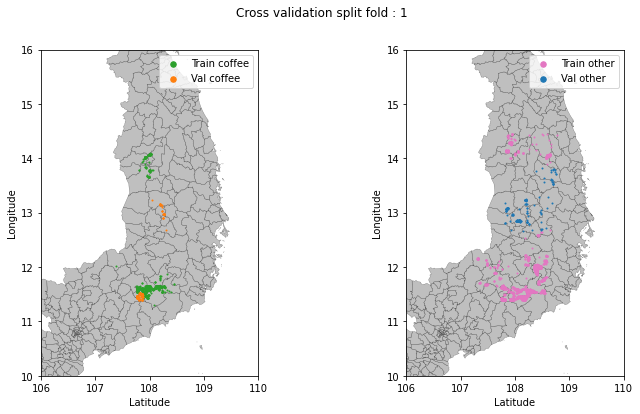

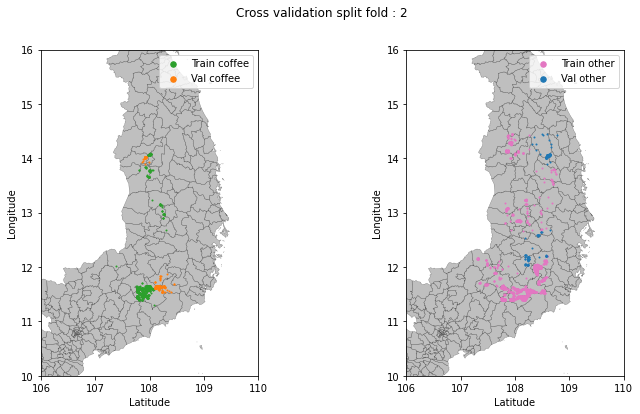

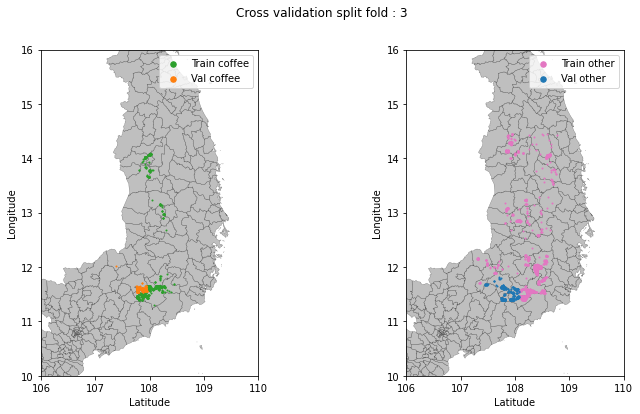

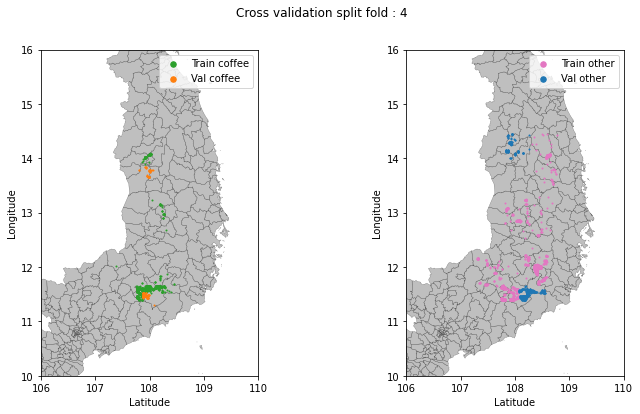

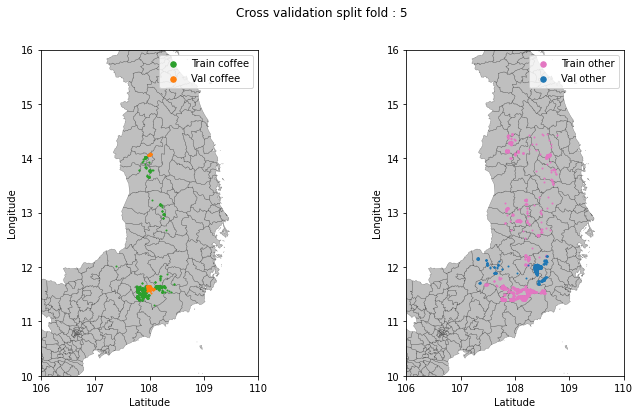

In [19]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold_32",f"train_{i_fold+1}_data_32.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold_32",f"val_{i_fold+1}_data_32.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {i_fold+1}")
    
    print(f"Fold {i_fold+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i_fold+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i_fold+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper],
                        class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

In [20]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [21]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.71484375
Stdev accuracy : 0.036810059341842956


Mean loss : 0.6475252985954285
Stdev loss : 0.12350760944062698


Mean precision : 0.8574742317199707
Stdev precision : 0.10591784553563116


Mean recall : 0.6654491662979126
Stdev recall : 0.15447350348674252


Mean F1-Score : 0.731045937538147
Stdev F1-Score : 0.09755954674382947


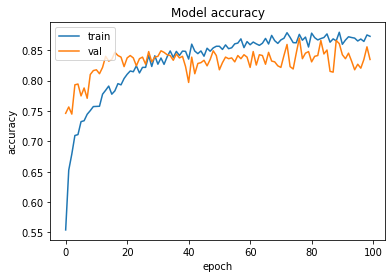

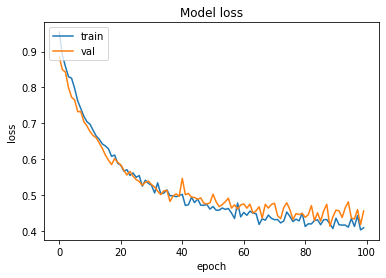

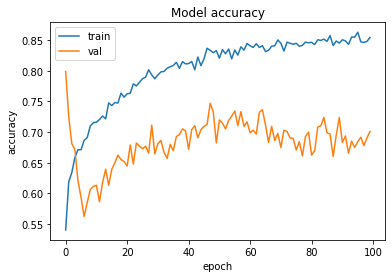

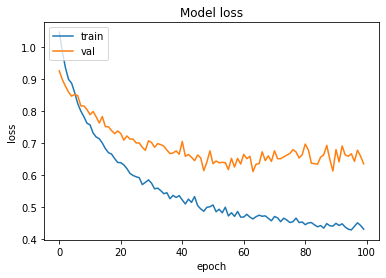

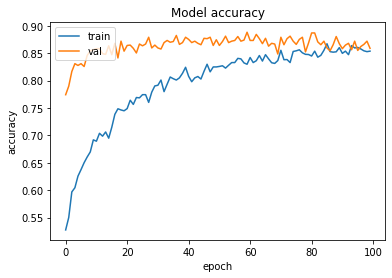

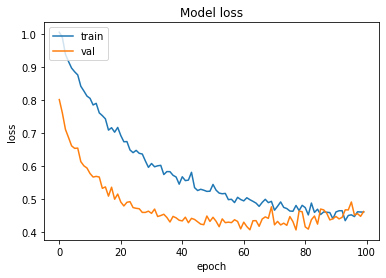

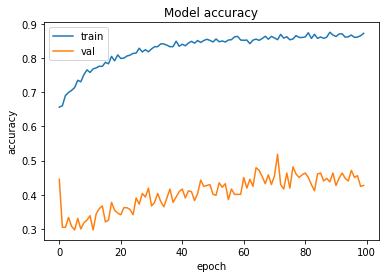

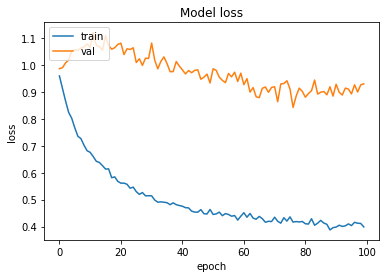

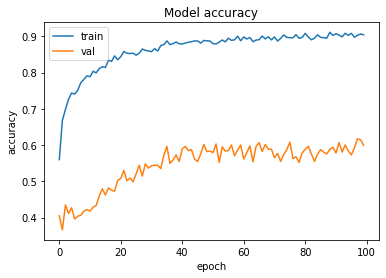

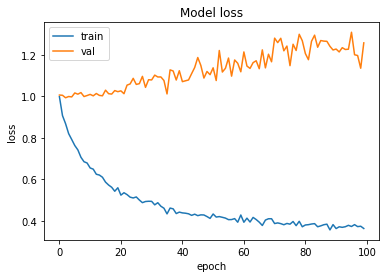

In [9]:
a = os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_spacv_10FOLD_coffee_2')
for i in os.listdir(a):
    if(i.split('.')[1] == 'npy'):
        chart = np.load(os.path.join(a, i), allow_pickle=True).item()
        
        # summarize history for accuracy
        plt.plot(chart['accuracy'])
        plt.plot(chart['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(chart['loss'])
        plt.plot(chart['val_loss'])
        plt.title('Model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

## Old

In [14]:
NB_FOLD = 10
skcv_coffee = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(other_data['geometry'])
list_fold = []
i = 0

for coffee, other in zip(skcv_coffee, skcv_other):  
    list_fold.append({"train_coffee":coffee[0], "train_other":other[0], "val_coffee":coffee[1], "val_other":other[1]})

In [15]:
random.shuffle(list_fold)

Fold 1 Number coffee - train : 1445
Fold 1 Number no-coffee - train : 5444
Fold 1 Number coffee - val : 384
Fold 1 Number no-coffee - val : 254
-----
Training for fold 0
Epoch 1/100
321/321 [==============================] - 47s 120ms/step - loss: 0.9242 - accuracy: 0.6185 - precision: 0.8058 - recall: 0.6867 - val_loss: 0.9413 - val_accuracy: 0.5648 - val_precision: 0.4760 - val_recall: 0.9534
Epoch 2/100
321/321 [==============================] - 36s 113ms/step - loss: 0.8624 - accuracy: 0.6762 - precision: 0.8258 - recall: 0.7486 - val_loss: 0.8836 - val_accuracy: 0.6852 - val_precision: 0.5793 - val_recall: 0.9231
Epoch 3/100
321/321 [==============================] - 36s 113ms/step - loss: 0.8154 - accuracy: 0.7065 - precision: 0.8412 - recall: 0.7735 - val_loss: 0.8434 - val_accuracy: 0.7274 - val_precision: 0.6073 - val_recall: 0.8955
Epoch 4/100
321/321 [==============================] - 36s 113ms/step - loss: 0.7732 - accuracy: 0.7163 - precision: 0.8499 - recall: 0.7768 - val

Epoch 72/100
321/321 [==============================] - 36s 113ms/step - loss: 0.4353 - accuracy: 0.8331 - precision: 0.9507 - recall: 0.8313 - val_loss: 0.4353 - val_accuracy: 0.8860 - val_precision: 0.8329 - val_recall: 0.8881
Epoch 73/100
321/321 [==============================] - 36s 113ms/step - loss: 0.4416 - accuracy: 0.8271 - precision: 0.9497 - recall: 0.8257 - val_loss: 0.4806 - val_accuracy: 0.8542 - val_precision: 0.7844 - val_recall: 0.8635
Epoch 74/100
321/321 [==============================] - 36s 114ms/step - loss: 0.4458 - accuracy: 0.8229 - precision: 0.9430 - recall: 0.8257 - val_loss: 0.4374 - val_accuracy: 0.8721 - val_precision: 0.8037 - val_recall: 0.8964
Epoch 75/100
321/321 [==============================] - 36s 113ms/step - loss: 0.4425 - accuracy: 0.8330 - precision: 0.9445 - recall: 0.8368 - val_loss: 0.4342 - val_accuracy: 0.8657 - val_precision: 0.8183 - val_recall: 0.8582
Epoch 76/100
321/321 [==============================] - 36s 113ms/step - loss: 0.444

Epoch 4/100
327/327 [==============================] - 36s 110ms/step - loss: 0.8072 - accuracy: 0.6738 - precision: 0.8377 - recall: 0.7099 - val_loss: 0.7721 - val_accuracy: 0.8125 - val_precision: 0.8974 - val_recall: 0.7709
Epoch 5/100
327/327 [==============================] - 36s 110ms/step - loss: 0.7629 - accuracy: 0.7066 - precision: 0.8576 - recall: 0.7417 - val_loss: 0.7401 - val_accuracy: 0.7943 - val_precision: 0.8737 - val_recall: 0.7621
Epoch 6/100
327/327 [==============================] - 36s 110ms/step - loss: 0.7372 - accuracy: 0.7100 - precision: 0.8657 - recall: 0.7317 - val_loss: 0.7001 - val_accuracy: 0.7943 - val_precision: 0.8914 - val_recall: 0.7267
Epoch 7/100
327/327 [==============================] - 36s 110ms/step - loss: 0.7168 - accuracy: 0.7105 - precision: 0.8677 - recall: 0.7311 - val_loss: 0.6795 - val_accuracy: 0.7682 - val_precision: 0.8739 - val_recall: 0.7111
Epoch 8/100
327/327 [==============================] - 36s 110ms/step - loss: 0.6926 - a

Epoch 75/100
327/327 [==============================] - 36s 111ms/step - loss: 0.4496 - accuracy: 0.8236 - precision: 0.9441 - recall: 0.8197 - val_loss: 0.4385 - val_accuracy: 0.8550 - val_precision: 0.9352 - val_recall: 0.8095
Epoch 76/100
327/327 [==============================] - 36s 110ms/step - loss: 0.4538 - accuracy: 0.8238 - precision: 0.9432 - recall: 0.8205 - val_loss: 0.4609 - val_accuracy: 0.8420 - val_precision: 0.9344 - val_recall: 0.7842
Epoch 77/100
327/327 [==============================] - 36s 110ms/step - loss: 0.4569 - accuracy: 0.8211 - precision: 0.9465 - recall: 0.8127 - val_loss: 0.4283 - val_accuracy: 0.8542 - val_precision: 0.9371 - val_recall: 0.8079
Epoch 78/100
327/327 [==============================] - 36s 111ms/step - loss: 0.4575 - accuracy: 0.8218 - precision: 0.9428 - recall: 0.8159 - val_loss: 0.4361 - val_accuracy: 0.8542 - val_precision: 0.9458 - val_recall: 0.7979
Epoch 79/100
327/327 [==============================] - 36s 111ms/step - loss: 0.467

Epoch 42/100
306/306 [==============================] - 36s 119ms/step - loss: 0.4934 - accuracy: 0.8022 - precision: 0.9448 - recall: 0.7885 - val_loss: 0.6605 - val_accuracy: 0.6652 - val_precision: 0.9024 - val_recall: 0.6053
Epoch 43/100
306/306 [==============================] - 36s 119ms/step - loss: 0.4936 - accuracy: 0.8018 - precision: 0.9389 - recall: 0.7902 - val_loss: 0.6376 - val_accuracy: 0.6920 - val_precision: 0.9185 - val_recall: 0.6283
Epoch 44/100
306/306 [==============================] - 36s 119ms/step - loss: 0.4816 - accuracy: 0.8071 - precision: 0.9432 - recall: 0.7946 - val_loss: 0.6554 - val_accuracy: 0.6685 - val_precision: 0.9235 - val_recall: 0.5875
Epoch 45/100
306/306 [==============================] - 36s 118ms/step - loss: 0.4852 - accuracy: 0.8137 - precision: 0.9440 - recall: 0.7997 - val_loss: 0.6451 - val_accuracy: 0.6719 - val_precision: 0.9209 - val_recall: 0.6037
Epoch 46/100
306/306 [==============================] - 36s 118ms/step - loss: 0.476

321/321 [==============================] - 37s 115ms/step - loss: 0.6129 - accuracy: 0.7451 - precision: 0.9141 - recall: 0.6993 - val_loss: 0.5480 - val_accuracy: 0.7140 - val_precision: 0.9945 - val_recall: 0.7094
Epoch 17/100
321/321 [==============================] - 37s 116ms/step - loss: 0.6019 - accuracy: 0.7531 - precision: 0.9165 - recall: 0.7100 - val_loss: 0.5178 - val_accuracy: 0.7377 - val_precision: 0.9960 - val_recall: 0.7329
Epoch 18/100
321/321 [==============================] - 37s 116ms/step - loss: 0.5904 - accuracy: 0.7522 - precision: 0.9201 - recall: 0.7068 - val_loss: 0.5240 - val_accuracy: 0.7311 - val_precision: 0.9953 - val_recall: 0.7270
Epoch 19/100
321/321 [==============================] - 37s 115ms/step - loss: 0.5793 - accuracy: 0.7650 - precision: 0.9269 - recall: 0.7173 - val_loss: 0.5260 - val_accuracy: 0.7301 - val_precision: 0.9953 - val_recall: 0.7251
Epoch 20/100
321/321 [==============================] - 37s 117ms/step - loss: 0.5810 - accuracy:

Epoch 87/100
321/321 [==============================] - 37s 115ms/step - loss: 0.4669 - accuracy: 0.8123 - precision: 0.9457 - recall: 0.7721 - val_loss: 0.4460 - val_accuracy: 0.7988 - val_precision: 0.9957 - val_recall: 0.7961
Epoch 88/100
321/321 [==============================] - 37s 115ms/step - loss: 0.4709 - accuracy: 0.8145 - precision: 0.9441 - recall: 0.7815 - val_loss: 0.4154 - val_accuracy: 0.8149 - val_precision: 0.9970 - val_recall: 0.8123
Epoch 89/100
321/321 [==============================] - 37s 116ms/step - loss: 0.4620 - accuracy: 0.8153 - precision: 0.9435 - recall: 0.7833 - val_loss: 0.4160 - val_accuracy: 0.8078 - val_precision: 0.9970 - val_recall: 0.8043
Epoch 90/100
321/321 [==============================] - 37s 115ms/step - loss: 0.4664 - accuracy: 0.8145 - precision: 0.9455 - recall: 0.7799 - val_loss: 0.4092 - val_accuracy: 0.8168 - val_precision: 0.9994 - val_recall: 0.8115
Epoch 91/100
321/321 [==============================] - 37s 115ms/step - loss: 0.467

Epoch 19/100
303/303 [==============================] - 37s 124ms/step - loss: 0.5709 - accuracy: 0.7778 - precision: 0.9132 - recall: 0.7570 - val_loss: 0.7126 - val_accuracy: 0.6710 - val_precision: 0.8590 - val_recall: 0.7239
Epoch 20/100
303/303 [==============================] - 37s 123ms/step - loss: 0.5707 - accuracy: 0.7742 - precision: 0.9172 - recall: 0.7467 - val_loss: 0.7077 - val_accuracy: 0.6780 - val_precision: 0.8575 - val_recall: 0.7283
Epoch 21/100
303/303 [==============================] - 37s 123ms/step - loss: 0.5561 - accuracy: 0.7811 - precision: 0.9226 - recall: 0.7576 - val_loss: 0.7044 - val_accuracy: 0.6846 - val_precision: 0.8655 - val_recall: 0.7321
Epoch 22/100
303/303 [==============================] - 37s 124ms/step - loss: 0.5510 - accuracy: 0.7875 - precision: 0.9186 - recall: 0.7691 - val_loss: 0.6976 - val_accuracy: 0.6745 - val_precision: 0.8518 - val_recall: 0.7292
Epoch 23/100
303/303 [==============================] - 37s 124ms/step - loss: 0.552

Epoch 55/100
303/303 [==============================] - 37s 123ms/step - loss: 0.4780 - accuracy: 0.8179 - precision: 0.9400 - recall: 0.7993 - val_loss: 0.6249 - val_accuracy: 0.7500 - val_precision: 0.9143 - val_recall: 0.7651
Epoch 56/100
303/303 [==============================] - 37s 124ms/step - loss: 0.4817 - accuracy: 0.8178 - precision: 0.9365 - recall: 0.7960 - val_loss: 0.6222 - val_accuracy: 0.7624 - val_precision: 0.9185 - val_recall: 0.7771
Epoch 57/100
303/303 [==============================] - 37s 123ms/step - loss: 0.4822 - accuracy: 0.8193 - precision: 0.9339 - recall: 0.8028 - val_loss: 0.6450 - val_accuracy: 0.7497 - val_precision: 0.9167 - val_recall: 0.7610
Epoch 58/100
303/303 [==============================] - 37s 123ms/step - loss: 0.4824 - accuracy: 0.8186 - precision: 0.9407 - recall: 0.7946 - val_loss: 0.6432 - val_accuracy: 0.7474 - val_precision: 0.9128 - val_recall: 0.7649
Epoch 59/100
303/303 [==============================] - 37s 123ms/step - loss: 0.477

Epoch 91/100
303/303 [==============================] - 37s 124ms/step - loss: 0.4588 - accuracy: 0.8238 - precision: 0.9373 - recall: 0.8079 - val_loss: 0.5782 - val_accuracy: 0.7827 - val_precision: 0.9356 - val_recall: 0.7867
Epoch 92/100
303/303 [==============================] - 37s 123ms/step - loss: 0.4619 - accuracy: 0.8246 - precision: 0.9370 - recall: 0.8056 - val_loss: 0.5922 - val_accuracy: 0.7786 - val_precision: 0.9345 - val_recall: 0.7825
Epoch 93/100
303/303 [==============================] - 37s 124ms/step - loss: 0.4456 - accuracy: 0.8308 - precision: 0.9421 - recall: 0.8119 - val_loss: 0.5967 - val_accuracy: 0.7772 - val_precision: 0.9371 - val_recall: 0.7814
Epoch 94/100
303/303 [==============================] - 38s 125ms/step - loss: 0.4470 - accuracy: 0.8287 - precision: 0.9423 - recall: 0.8082 - val_loss: 0.6167 - val_accuracy: 0.7703 - val_precision: 0.9344 - val_recall: 0.7740
Epoch 95/100
303/303 [==============================] - 37s 123ms/step - loss: 0.450

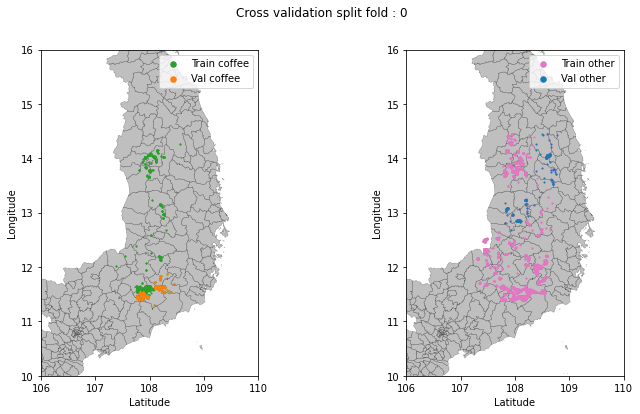

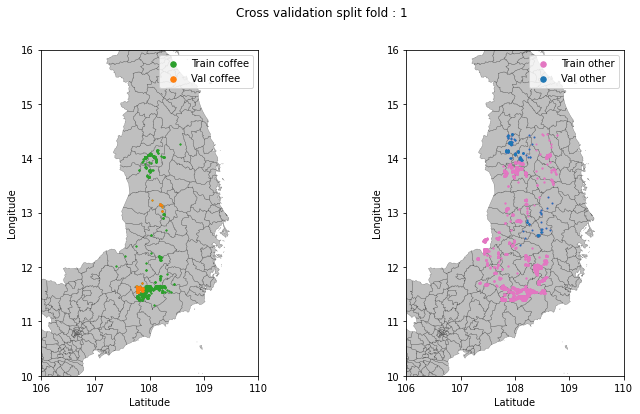

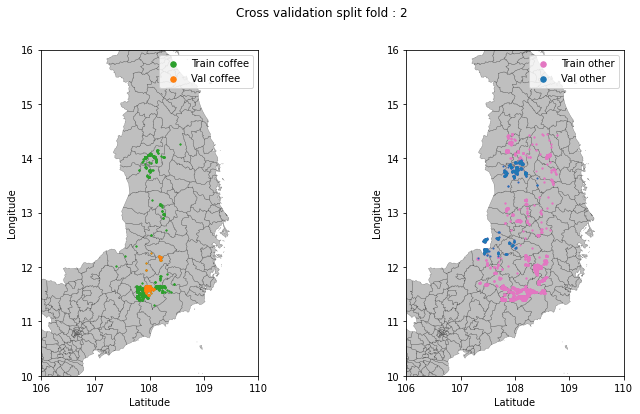

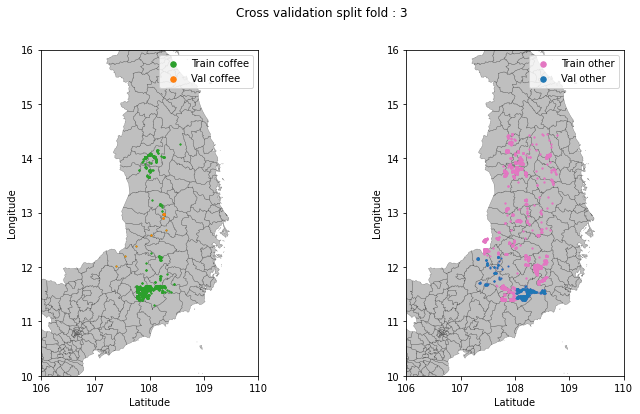

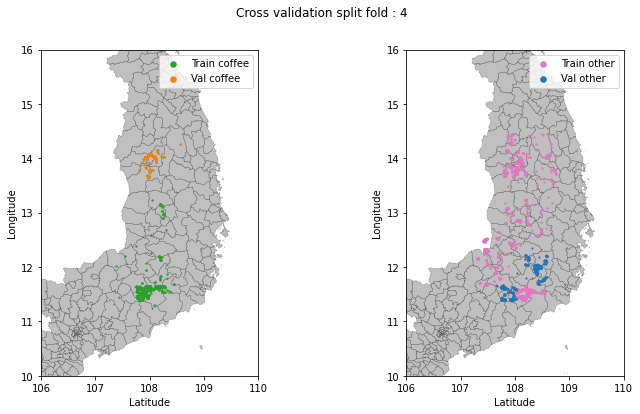

In [16]:
skcv_coffee = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(other_data['geometry'])

fold_index = 0

results = []

for i_fold in range(0, len(list_fold), 2):

    first_fold = list_fold[i_fold]
    second_fold = list_fold[i_fold+1]
    
    train_coffee = np.concatenate([first_fold["train_coffee"], second_fold["train_coffee"]])
    val_coffee = np.concatenate([first_fold["val_coffee"], second_fold["val_coffee"]])
    train_other = np.concatenate([first_fold["train_other"], second_fold["train_other"]])
    val_other = np.concatenate([first_fold["val_other"], second_fold["val_other"]])
    
    geo_train = coffee_data.iloc[train_coffee].append(other_data.iloc[train_other], ignore_index=True)
    geo_val = coffee_data.iloc[val_coffee].append(other_data.iloc[val_other], ignore_index=True)
    
    print(f"Fold {fold_index+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {fold_index+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {fold_index+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {fold_index+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print("-----")

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {fold_index}")
    
    print(f"Training for fold {fold_index}")

    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper],
                        class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

    fold_index+=1

In [17]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [18]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.81328125
Stdev accuracy : 0.04490658707249973


Mean loss : 0.47894980311393737
Stdev loss : 0.05015097601057497


Mean precision : 0.9178672432899475
Stdev precision : 0.0738321460496677


Mean recall : 0.8066516876220703
Stdev recall : 0.06774728165123221


Mean F1-Score : 0.8538654512458315
Stdev F1-Score : 0.034182052731561316


In [16]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Coffee/strat_spacv_coffee_32_1/strat_spacv_coffee_32_1_1.h5"), custom_objects={'LeakyReLU':LeakyReLU})
#restored_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

In [17]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_test_32.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

data_test.loc[data_test['label'] != 2, 'label'] = 1
data_test.loc[data_test['label'] == 2, 'label'] = 0

1/1 [==============================] - 6s 6s/step - loss: 0.6726 - accuracy: 0.7042 - precision: 0.7732 - recall: 0.8785
              precision    recall  f1-score   support

           0       0.22      0.12      0.16       211
           1       0.78      0.87      0.82       749

    accuracy                           0.71       960
   macro avg       0.50      0.50      0.49       960
weighted avg       0.66      0.71      0.68       960

F1-Score : 0.8244178728760226


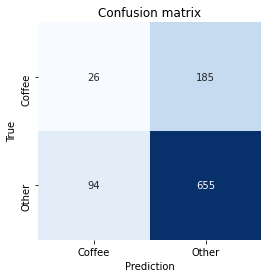

In [18]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

### Stratified cross-val

In [8]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'new_strat_spring_train.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

In [9]:
nb_0 = len(data_train[data_train['label']==0])
nb_1 = len(data_train[data_train['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [10]:
# Params
BATCH_SIZE = 256
EPOCH = 300
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'start_coffee_300E_focal_2'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [11]:

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(loss=BinaryFocalLoss(gamma=2), optimizer=Adam(learning_rate=LEARNING_RATE), metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper],
                                class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1
    

Epoch 1/300
15/15 [==============================] - 20s 771ms/step - loss: 0.5212 - accuracy: 0.5594 - precision: 0.7806 - recall: 0.5906 - val_loss: 0.4492 - val_accuracy: 0.7201 - val_precision: 0.8429 - val_recall: 0.7782
Epoch 2/300
15/15 [==============================] - 9s 612ms/step - loss: 0.5094 - accuracy: 0.5752 - precision: 0.7648 - recall: 0.6198 - val_loss: 0.4413 - val_accuracy: 0.7266 - val_precision: 0.8602 - val_recall: 0.7662
Epoch 3/300
15/15 [==============================] - 9s 619ms/step - loss: 0.4908 - accuracy: 0.6080 - precision: 0.7894 - recall: 0.6524 - val_loss: 0.4343 - val_accuracy: 0.7279 - val_precision: 0.8661 - val_recall: 0.7573
Epoch 4/300
15/15 [==============================] - 9s 616ms/step - loss: 0.4822 - accuracy: 0.6154 - precision: 0.8024 - recall: 0.6457 - val_loss: 0.4305 - val_accuracy: 0.7240 - val_precision: 0.9022 - val_recall: 0.7131
Epoch 5/300
15/15 [==============================] - 9s 603ms/step - loss: 0.4742 - accuracy: 0.615

15/15 [==============================] - 9s 632ms/step - loss: 0.2894 - accuracy: 0.7883 - precision: 0.9238 - recall: 0.7870 - val_loss: 0.2812 - val_accuracy: 0.7917 - val_precision: 0.9367 - val_recall: 0.7806
Epoch 74/300
15/15 [==============================] - 9s 638ms/step - loss: 0.2803 - accuracy: 0.8007 - precision: 0.9347 - recall: 0.7950 - val_loss: 0.2812 - val_accuracy: 0.7891 - val_precision: 0.9391 - val_recall: 0.7707
Epoch 75/300
15/15 [==============================] - 9s 645ms/step - loss: 0.2890 - accuracy: 0.7856 - precision: 0.9214 - recall: 0.7850 - val_loss: 0.2785 - val_accuracy: 0.8060 - val_precision: 0.9605 - val_recall: 0.7804
Epoch 76/300
15/15 [==============================] - 9s 642ms/step - loss: 0.2821 - accuracy: 0.7943 - precision: 0.9376 - recall: 0.7815 - val_loss: 0.2794 - val_accuracy: 0.7917 - val_precision: 0.9443 - val_recall: 0.7750
Epoch 77/300
15/15 [==============================] - 9s 620ms/step - loss: 0.2825 - accuracy: 0.7974 - preci

15/15 [==============================] - 9s 639ms/step - loss: 0.2284 - accuracy: 0.8001 - precision: 0.9350 - recall: 0.7915 - val_loss: 0.2215 - val_accuracy: 0.8125 - val_precision: 0.9478 - val_recall: 0.7923
Epoch 146/300
15/15 [==============================] - 9s 630ms/step - loss: 0.2296 - accuracy: 0.8015 - precision: 0.9452 - recall: 0.7866 - val_loss: 0.2205 - val_accuracy: 0.8294 - val_precision: 0.9679 - val_recall: 0.8074
Epoch 147/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2285 - accuracy: 0.8020 - precision: 0.9352 - recall: 0.7922 - val_loss: 0.2211 - val_accuracy: 0.8190 - val_precision: 0.9530 - val_recall: 0.8007
Epoch 148/300
15/15 [==============================] - 9s 637ms/step - loss: 0.2218 - accuracy: 0.8095 - precision: 0.9397 - recall: 0.8066 - val_loss: 0.2220 - val_accuracy: 0.8229 - val_precision: 0.9503 - val_recall: 0.8115
Epoch 149/300
15/15 [==============================] - 9s 641ms/step - loss: 0.2224 - accuracy: 0.8180 - p

15/15 [==============================] - 9s 642ms/step - loss: 0.3640 - accuracy: 0.7305 - precision: 0.8973 - recall: 0.7266 - val_loss: 0.3419 - val_accuracy: 0.8021 - val_precision: 0.9213 - val_recall: 0.8069
Epoch 35/300
15/15 [==============================] - 9s 653ms/step - loss: 0.3578 - accuracy: 0.7332 - precision: 0.9054 - recall: 0.7265 - val_loss: 0.3410 - val_accuracy: 0.8060 - val_precision: 0.9226 - val_recall: 0.8140
Epoch 36/300
15/15 [==============================] - 9s 621ms/step - loss: 0.3534 - accuracy: 0.7508 - precision: 0.9045 - recall: 0.7445 - val_loss: 0.3367 - val_accuracy: 0.8164 - val_precision: 0.9129 - val_recall: 0.8354
Epoch 37/300
15/15 [==============================] - 9s 628ms/step - loss: 0.3521 - accuracy: 0.7461 - precision: 0.9042 - recall: 0.7454 - val_loss: 0.3334 - val_accuracy: 0.8164 - val_precision: 0.9198 - val_recall: 0.8296
Epoch 38/300
15/15 [==============================] - 9s 642ms/step - loss: 0.3535 - accuracy: 0.7415 - preci

15/15 [==============================] - 9s 633ms/step - loss: 0.2526 - accuracy: 0.8038 - precision: 0.9298 - recall: 0.8020 - val_loss: 0.2384 - val_accuracy: 0.8451 - val_precision: 0.9266 - val_recall: 0.8647
Epoch 107/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2523 - accuracy: 0.7867 - precision: 0.9246 - recall: 0.7866 - val_loss: 0.2370 - val_accuracy: 0.8633 - val_precision: 0.9352 - val_recall: 0.8783
Epoch 108/300
15/15 [==============================] - 9s 623ms/step - loss: 0.2532 - accuracy: 0.7903 - precision: 0.9305 - recall: 0.7790 - val_loss: 0.2381 - val_accuracy: 0.8477 - val_precision: 0.9316 - val_recall: 0.8630
Epoch 109/300
15/15 [==============================] - 9s 632ms/step - loss: 0.2558 - accuracy: 0.7921 - precision: 0.9156 - recall: 0.7972 - val_loss: 0.2361 - val_accuracy: 0.8555 - val_precision: 0.9404 - val_recall: 0.8647
Epoch 110/300
15/15 [==============================] - 9s 628ms/step - loss: 0.2491 - accuracy: 0.7934 - p

15/15 [==============================] - 9s 636ms/step - loss: 0.3204 - accuracy: 0.7739 - precision: 0.9254 - recall: 0.7616 - val_loss: 0.3077 - val_accuracy: 0.8008 - val_precision: 0.9270 - val_recall: 0.8020
Epoch 53/300
15/15 [==============================] - 9s 634ms/step - loss: 0.3228 - accuracy: 0.7497 - precision: 0.9185 - recall: 0.7403 - val_loss: 0.3040 - val_accuracy: 0.8047 - val_precision: 0.9249 - val_recall: 0.8069
Epoch 54/300
15/15 [==============================] - 9s 635ms/step - loss: 0.3185 - accuracy: 0.7707 - precision: 0.9240 - recall: 0.7629 - val_loss: 0.3049 - val_accuracy: 0.7995 - val_precision: 0.9249 - val_recall: 0.7958
Epoch 55/300
15/15 [==============================] - 9s 629ms/step - loss: 0.3142 - accuracy: 0.7604 - precision: 0.9215 - recall: 0.7536 - val_loss: 0.3018 - val_accuracy: 0.8125 - val_precision: 0.9294 - val_recall: 0.8144
Epoch 56/300
15/15 [==============================] - 9s 631ms/step - loss: 0.3167 - accuracy: 0.7524 - preci

15/15 [==============================] - 9s 627ms/step - loss: 0.2386 - accuracy: 0.8119 - precision: 0.9371 - recall: 0.8066 - val_loss: 0.2274 - val_accuracy: 0.8320 - val_precision: 0.9528 - val_recall: 0.8220
Epoch 125/300
15/15 [==============================] - 9s 628ms/step - loss: 0.2404 - accuracy: 0.8007 - precision: 0.9326 - recall: 0.7943 - val_loss: 0.2265 - val_accuracy: 0.8385 - val_precision: 0.9508 - val_recall: 0.8299
Epoch 126/300
15/15 [==============================] - 9s 640ms/step - loss: 0.2358 - accuracy: 0.8148 - precision: 0.9334 - recall: 0.8141 - val_loss: 0.2264 - val_accuracy: 0.8255 - val_precision: 0.9492 - val_recall: 0.8182
Epoch 127/300
15/15 [==============================] - 9s 634ms/step - loss: 0.2362 - accuracy: 0.8138 - precision: 0.9446 - recall: 0.8020 - val_loss: 0.2253 - val_accuracy: 0.8229 - val_precision: 0.9365 - val_recall: 0.8194
Epoch 128/300
15/15 [==============================] - 9s 624ms/step - loss: 0.2341 - accuracy: 0.8096 - p

15/15 [==============================] - 9s 635ms/step - loss: 0.3189 - accuracy: 0.7660 - precision: 0.9276 - recall: 0.7487 - val_loss: 0.3023 - val_accuracy: 0.8021 - val_precision: 0.9296 - val_recall: 0.7979
Epoch 52/300
15/15 [==============================] - 9s 642ms/step - loss: 0.3199 - accuracy: 0.7610 - precision: 0.9228 - recall: 0.7431 - val_loss: 0.2976 - val_accuracy: 0.8034 - val_precision: 0.9323 - val_recall: 0.8000
Epoch 53/300
15/15 [==============================] - 9s 622ms/step - loss: 0.3237 - accuracy: 0.7581 - precision: 0.9073 - recall: 0.7498 - val_loss: 0.2992 - val_accuracy: 0.8034 - val_precision: 0.9359 - val_recall: 0.7969
Epoch 54/300
15/15 [==============================] - 9s 632ms/step - loss: 0.3109 - accuracy: 0.7645 - precision: 0.9278 - recall: 0.7499 - val_loss: 0.2979 - val_accuracy: 0.7969 - val_precision: 0.9393 - val_recall: 0.7864
Epoch 55/300
15/15 [==============================] - 9s 640ms/step - loss: 0.3154 - accuracy: 0.7709 - preci

15/15 [==============================] - 9s 626ms/step - loss: 0.2402 - accuracy: 0.7941 - precision: 0.9309 - recall: 0.7864 - val_loss: 0.2246 - val_accuracy: 0.8242 - val_precision: 0.9449 - val_recall: 0.8177
Epoch 124/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2389 - accuracy: 0.8005 - precision: 0.9318 - recall: 0.7950 - val_loss: 0.2284 - val_accuracy: 0.8073 - val_precision: 0.9375 - val_recall: 0.7990
Epoch 125/300
15/15 [==============================] - 9s 642ms/step - loss: 0.2396 - accuracy: 0.7983 - precision: 0.9359 - recall: 0.7826 - val_loss: 0.2239 - val_accuracy: 0.8242 - val_precision: 0.9483 - val_recall: 0.8140
Epoch 126/300
15/15 [==============================] - 9s 637ms/step - loss: 0.2319 - accuracy: 0.7960 - precision: 0.9398 - recall: 0.7809 - val_loss: 0.2219 - val_accuracy: 0.8229 - val_precision: 0.9429 - val_recall: 0.8174
Epoch 127/300
15/15 [==============================] - 9s 621ms/step - loss: 0.2322 - accuracy: 0.7998 - p

15/15 [==============================] - 9s 636ms/step - loss: 0.3066 - accuracy: 0.7701 - precision: 0.9304 - recall: 0.7591 - val_loss: 0.3024 - val_accuracy: 0.7826 - val_precision: 0.9314 - val_recall: 0.7698
Epoch 58/300
15/15 [==============================] - 9s 621ms/step - loss: 0.3069 - accuracy: 0.7802 - precision: 0.9258 - recall: 0.7732 - val_loss: 0.3012 - val_accuracy: 0.8021 - val_precision: 0.9479 - val_recall: 0.7818
Epoch 59/300
15/15 [==============================] - 9s 624ms/step - loss: 0.3124 - accuracy: 0.7614 - precision: 0.9144 - recall: 0.7529 - val_loss: 0.3000 - val_accuracy: 0.7865 - val_precision: 0.9490 - val_recall: 0.7615
Epoch 60/300
15/15 [==============================] - 9s 630ms/step - loss: 0.3084 - accuracy: 0.7569 - precision: 0.9183 - recall: 0.7521 - val_loss: 0.2963 - val_accuracy: 0.7839 - val_precision: 0.9367 - val_recall: 0.7655
Epoch 61/300
15/15 [==============================] - 9s 644ms/step - loss: 0.3127 - accuracy: 0.7641 - preci

In [16]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [17]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.58359375
Stdev accuracy : 0.07807029334596483


Mean loss : 0.834881043434143
Stdev loss : 0.1612857133843908


Mean precision : 0.7884676456451416
Stdev precision : 0.16546708969100746


Mean recall : 0.7146665096282959
Stdev recall : 0.1829823240399447


Mean F1-Score : 0.7121207962023967
Stdev F1-Score : 0.06579899948742093


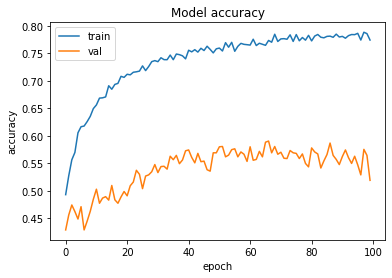

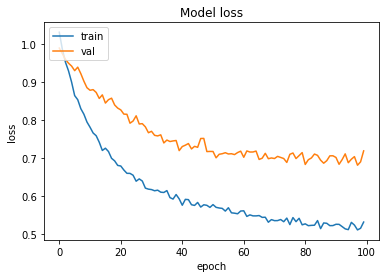

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Coffee/start_coffee_300E_focal_2/start_coffee_300E_focal_2_3.h5"), custom_objects={'LeakyReLU':LeakyReLU})

In [22]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'new_strat_spring_test.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

1/1 [==============================] - 3s 3s/step - loss: 0.2277 - accuracy: 0.8257 - precision: 0.9414 - recall: 0.8211
              precision    recall  f1-score   support

           0       0.57      0.82      0.67       100
           1       0.93      0.80      0.86       313

    accuracy                           0.81       413
   macro avg       0.75      0.81      0.77       413
weighted avg       0.85      0.81      0.82       413

F1-Score : 0.8625429553264605


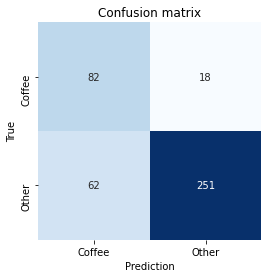

In [23]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Culture vs no culture

In [8]:
culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree

nb_culture = 0
for c in culture_list:
    nb_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

nb_no_culture = 0
for c in no_culture_list:
    nb_no_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

In [9]:
path_culture = []

for c in culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_culture.append(os.path.join(IMAGES_DIR, str(c), name))
np.random.shuffle(path_culture)
class_culture = [0]*len(path_culture)
        
path_no_culture = []

for c in no_culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_no_culture.append(os.path.join(IMAGES_DIR, str(c), name))
np.random.shuffle(path_no_culture)
class_no_culture = [1]*len(path_no_culture)

In [10]:
file_paths = np.asarray(path_culture + path_no_culture)
classes = np.asarray(class_culture + class_no_culture)

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.25, random_state=42)

In [11]:
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 2
EPOCH = 100
RUN_NAME = 'transfer_culture_vietnam_params'
LOGS_PATH = 'logs'

In [13]:
train_generator = generator(path_train, y_train, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)

## Model creation

In [12]:
model_culture = create_model()
model_culture.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv5_block27_2_conv (Conv2D)   (None, 2, 2, 32)     36864       conv5_block27_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block27_concat (Concatena (None, 2, 2, 1760)   0           conv5_block26_concat[0][0]       
                                                                 conv5_block27_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block28_0_bn (BatchNormal (None, 2, 2, 1760)   7040        conv5_block27_concat[0][0]       
__________________________________________________________________________________________________
conv5_block28_0_relu (Activatio (None, 2, 2, 1760)   0           conv5_block28_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block28_1_conv (Conv2D)   (None, 2, 2, 128)    225280      conv5_block28_0_relu[0][0]       
__________

In [16]:
# Run only for modify input shape
model_culture = change_model(model_culture, new_input_shape=(None, 32,32,13))
model_culture.summary()

Loaded layer input_1
Loaded layer zero_padding2d
Loaded layer conv1/conv
Loaded layer conv1/bn
Loaded layer conv1/relu
Loaded layer zero_padding2d_1
Loaded layer pool1
Loaded layer conv2_block1_0_bn
Loaded layer conv2_block1_0_relu
Loaded layer conv2_block1_1_conv
Loaded layer conv2_block1_1_bn
Loaded layer conv2_block1_1_relu
Loaded layer conv2_block1_2_conv
Loaded layer conv2_block1_concat
Loaded layer conv2_block2_0_bn
Loaded layer conv2_block2_0_relu
Loaded layer conv2_block2_1_conv
Loaded layer conv2_block2_1_bn
Loaded layer conv2_block2_1_relu
Loaded layer conv2_block2_2_conv
Loaded layer conv2_block2_concat
Loaded layer conv2_block3_0_bn
Loaded layer conv2_block3_0_relu
Loaded layer conv2_block3_1_conv
Loaded layer conv2_block3_1_bn
Loaded layer conv2_block3_1_relu
Loaded layer conv2_block3_2_conv
Loaded layer conv2_block3_concat
Loaded layer conv2_block4_0_bn
Loaded layer conv2_block4_0_relu
Loaded layer conv2_block4_1_conv
Loaded layer conv2_block4_1_bn
Loaded layer conv2_bloc

Loaded layer conv4_block23_concat
Loaded layer conv4_block24_0_bn
Loaded layer conv4_block24_0_relu
Loaded layer conv4_block24_1_conv
Loaded layer conv4_block24_1_bn
Loaded layer conv4_block24_1_relu
Loaded layer conv4_block24_2_conv
Loaded layer conv4_block24_concat
Loaded layer conv4_block25_0_bn
Loaded layer conv4_block25_0_relu
Loaded layer conv4_block25_1_conv
Loaded layer conv4_block25_1_bn
Loaded layer conv4_block25_1_relu
Loaded layer conv4_block25_2_conv
Loaded layer conv4_block25_concat
Loaded layer conv4_block26_0_bn
Loaded layer conv4_block26_0_relu
Loaded layer conv4_block26_1_conv
Loaded layer conv4_block26_1_bn
Loaded layer conv4_block26_1_relu
Loaded layer conv4_block26_2_conv
Loaded layer conv4_block26_concat
Loaded layer conv4_block27_0_bn
Loaded layer conv4_block27_0_relu
Loaded layer conv4_block27_1_conv
Loaded layer conv4_block27_1_bn
Loaded layer conv4_block27_1_relu
Loaded layer conv4_block27_2_conv
Loaded layer conv4_block27_concat
Loaded layer conv4_block28_0_b

Loaded layer conv5_block17_concat
Loaded layer conv5_block18_0_bn
Loaded layer conv5_block18_0_relu
Loaded layer conv5_block18_1_conv
Loaded layer conv5_block18_1_bn
Loaded layer conv5_block18_1_relu
Loaded layer conv5_block18_2_conv
Loaded layer conv5_block18_concat
Loaded layer conv5_block19_0_bn
Loaded layer conv5_block19_0_relu
Loaded layer conv5_block19_1_conv
Loaded layer conv5_block19_1_bn
Loaded layer conv5_block19_1_relu
Loaded layer conv5_block19_2_conv
Loaded layer conv5_block19_concat
Loaded layer conv5_block20_0_bn
Loaded layer conv5_block20_0_relu
Loaded layer conv5_block20_1_conv
Loaded layer conv5_block20_1_bn
Loaded layer conv5_block20_1_relu
Loaded layer conv5_block20_2_conv
Loaded layer conv5_block20_concat
Loaded layer conv5_block21_0_bn
Loaded layer conv5_block21_0_relu
Loaded layer conv5_block21_1_conv
Loaded layer conv5_block21_1_bn
Loaded layer conv5_block21_1_relu
Loaded layer conv5_block21_2_conv
Loaded layer conv5_block21_concat
Loaded layer conv5_block22_0_b

__________________________________________________________________________________________________
conv4_block15_0_bn (BatchNormal (None, 2, 2, 704)    2816        conv4_block14_concat[0][0]       
__________________________________________________________________________________________________
conv4_block15_0_relu (Activatio (None, 2, 2, 704)    0           conv4_block15_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block15_1_conv (Conv2D)   (None, 2, 2, 128)    90112       conv4_block15_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_bn (BatchNormal (None, 2, 2, 128)    512         conv4_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_relu (Activatio (None, 2, 2, 128)    0           conv4_block15_1_bn[0][0]         
__________

In [57]:
os.mkdir(os.path.join(LOGS_PATH, RUN_NAME))

earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
#tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/transfer_culture_vietnam_params'

In [58]:


model_culture.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model_culture.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper])

Epoch 1/100
174/174 [==============================] - 39s 188ms/step - loss: 1.7473 - accuracy: 0.5251 - val_loss: 1.6164 - val_accuracy: 0.5665
Epoch 2/100
174/174 [==============================] - 31s 177ms/step - loss: 1.6062 - accuracy: 0.5555 - val_loss: 1.4959 - val_accuracy: 0.6498
Epoch 3/100
174/174 [==============================] - 31s 177ms/step - loss: 1.4909 - accuracy: 0.5773 - val_loss: 1.3913 - val_accuracy: 0.6856
Epoch 4/100
174/174 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.6003

KeyboardInterrupt: 

In [18]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

model_culture.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.npy'),history.history)

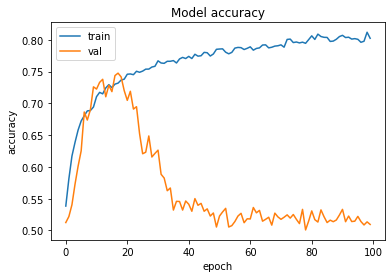

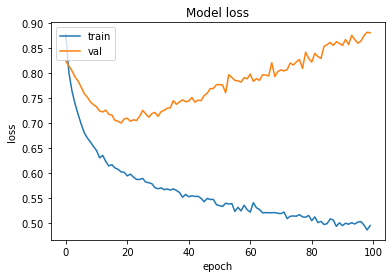

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model evaluation

In [20]:
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
model_culture.evaluate_generator(test_generator,30)

[0.46674337685108186, 0.8041667]

In [42]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(model_culture.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [43]:
cm = confusion_matrix(Y_true, Y_pred)

In [41]:
plot_confusion_matrix(cm)

TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'X' and 'y_true'

In [45]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1055
           1       0.75      0.73      0.74       865

    accuracy                           0.77      1920
   macro avg       0.76      0.76      0.76      1920
weighted avg       0.77      0.77      0.77      1920

F1-Score : 0.7366568914956012


### Spatial - Cross Validation

In [9]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'final_spacv_10FOLD_coffee_ds2'
NB_FOLD = 5

results= []

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

In [10]:
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

Fold 1 Number culture - train : 752
Fold 1 Number no-culture - train : 566
Fold 1 Number culture - val : 72
Fold 1 Number no-culture - val : 72
Training for fold 1
-----
Epoch 1/100
40/40 [==============================] - 16s 200ms/step - loss: 0.9179 - accuracy: 0.6237 - precision: 0.5796 - recall: 0.5282 - f1_score_keras: 0.5486 - val_loss: 0.5509 - val_accuracy: 0.9766 - val_precision: 0.9914 - val_recall: 0.9583 - val_f1_score_keras: 0.9733
Epoch 2/100
40/40 [==============================] - 5s 136ms/step - loss: 0.7137 - accuracy: 0.7831 - precision: 0.8286 - recall: 0.5909 - f1_score_keras: 0.6885 - val_loss: 0.4280 - val_accuracy: 0.9570 - val_precision: 0.9836 - val_recall: 0.9302 - val_f1_score_keras: 0.9561
Epoch 3/100
40/40 [==============================] - 5s 134ms/step - loss: 0.6222 - accuracy: 0.8081 - precision: 0.8784 - recall: 0.6628 - f1_score_keras: 0.7557 - val_loss: 0.3944 - val_accuracy: 0.9570 - val_precision: 0.9504 - val_recall: 0.9583 - val_f1_score_keras:

Epoch 30/100
40/40 [==============================] - 5s 137ms/step - loss: 0.3354 - accuracy: 0.9155 - precision: 0.9061 - recall: 0.8904 - f1_score_keras: 0.8964 - val_loss: 0.3109 - val_accuracy: 0.8945 - val_precision: 0.8550 - val_recall: 0.9333 - val_f1_score_keras: 0.8913
Epoch 31/100
40/40 [==============================] - 5s 138ms/step - loss: 0.3249 - accuracy: 0.9244 - precision: 0.9350 - recall: 0.8832 - f1_score_keras: 0.9075 - val_loss: 0.2869 - val_accuracy: 0.9219 - val_precision: 0.8889 - val_recall: 0.9697 - val_f1_score_keras: 0.9261
Epoch 32/100
40/40 [==============================] - 5s 134ms/step - loss: 0.3371 - accuracy: 0.9142 - precision: 0.9140 - recall: 0.8685 - f1_score_keras: 0.8886 - val_loss: 0.3052 - val_accuracy: 0.8945 - val_precision: 0.8623 - val_recall: 0.9370 - val_f1_score_keras: 0.8944
Epoch 33/100
40/40 [==============================] - 5s 135ms/step - loss: 0.3160 - accuracy: 0.9163 - precision: 0.9137 - recall: 0.8972 - f1_score_keras: 0.9

Epoch 8/100
38/38 [==============================] - 5s 140ms/step - loss: 0.4318 - accuracy: 0.8850 - precision: 0.8927 - recall: 0.8240 - f1_score_keras: 0.8545 - val_loss: 0.5458 - val_accuracy: 0.8698 - val_precision: 0.9646 - val_recall: 0.8162 - val_f1_score_keras: 0.8846
Epoch 9/100
38/38 [==============================] - 5s 140ms/step - loss: 0.4203 - accuracy: 0.8807 - precision: 0.8885 - recall: 0.8055 - f1_score_keras: 0.8429 - val_loss: 0.5707 - val_accuracy: 0.8333 - val_precision: 0.9394 - val_recall: 0.7815 - val_f1_score_keras: 0.8520
Epoch 10/100
38/38 [==============================] - 5s 142ms/step - loss: 0.4170 - accuracy: 0.8914 - precision: 0.8993 - recall: 0.8239 - f1_score_keras: 0.8590 - val_loss: 0.5600 - val_accuracy: 0.8411 - val_precision: 0.9278 - val_recall: 0.7930 - val_f1_score_keras: 0.8545
Epoch 11/100
38/38 [==============================] - 5s 142ms/step - loss: 0.4307 - accuracy: 0.8764 - precision: 0.8928 - recall: 0.8126 - f1_score_keras: 0.845

38/38 [==============================] - 5s 139ms/step - loss: 0.2550 - accuracy: 0.9373 - precision: 0.9552 - recall: 0.8929 - f1_score_keras: 0.9204 - val_loss: 0.5572 - val_accuracy: 0.8359 - val_precision: 0.8969 - val_recall: 0.8333 - val_f1_score_keras: 0.8614
Epoch 67/100
38/38 [==============================] - 5s 140ms/step - loss: 0.2857 - accuracy: 0.9204 - precision: 0.9186 - recall: 0.8867 - f1_score_keras: 0.8991 - val_loss: 0.5818 - val_accuracy: 0.8177 - val_precision: 0.8565 - val_recall: 0.8259 - val_f1_score_keras: 0.8388
Epoch 68/100
38/38 [==============================] - 5s 139ms/step - loss: 0.2726 - accuracy: 0.9329 - precision: 0.9287 - recall: 0.8986 - f1_score_keras: 0.9126 - val_loss: 0.6852 - val_accuracy: 0.7995 - val_precision: 0.8312 - val_recall: 0.8419 - val_f1_score_keras: 0.8324
Epoch 69/100
38/38 [==============================] - 5s 140ms/step - loss: 0.2680 - accuracy: 0.9386 - precision: 0.9309 - recall: 0.9057 - f1_score_keras: 0.9173 - val_los

Epoch 21/100
36/36 [==============================] - 5s 146ms/step - loss: 0.3569 - accuracy: 0.9094 - precision: 0.9115 - recall: 0.8932 - f1_score_keras: 0.9010 - val_loss: 0.5222 - val_accuracy: 0.8457 - val_precision: 0.6391 - val_recall: 0.7328 - val_f1_score_keras: 0.6741
Epoch 22/100
36/36 [==============================] - 5s 145ms/step - loss: 0.3735 - accuracy: 0.8897 - precision: 0.8977 - recall: 0.8576 - f1_score_keras: 0.8741 - val_loss: 0.4580 - val_accuracy: 0.8730 - val_precision: 0.6406 - val_recall: 0.8119 - val_f1_score_keras: 0.7105
Epoch 23/100
36/36 [==============================] - 5s 147ms/step - loss: 0.3775 - accuracy: 0.8961 - precision: 0.9115 - recall: 0.8764 - f1_score_keras: 0.8926 - val_loss: 0.5110 - val_accuracy: 0.8457 - val_precision: 0.6107 - val_recall: 0.7407 - val_f1_score_keras: 0.6710
Epoch 24/100
36/36 [==============================] - 5s 146ms/step - loss: 0.3786 - accuracy: 0.8878 - precision: 0.9006 - recall: 0.8559 - f1_score_keras: 0.8

Epoch 28/100
32/32 [==============================] - 5s 163ms/step - loss: 0.3038 - accuracy: 0.9279 - precision: 0.9325 - recall: 0.9213 - f1_score_keras: 0.9250 - val_loss: 0.6844 - val_accuracy: 0.7891 - val_precision: 0.6488 - val_recall: 0.5142 - val_f1_score_keras: 0.5528
Epoch 29/100
32/32 [==============================] - 5s 163ms/step - loss: 0.3246 - accuracy: 0.9253 - precision: 0.9392 - recall: 0.9169 - f1_score_keras: 0.9279 - val_loss: 0.6846 - val_accuracy: 0.7930 - val_precision: 0.6525 - val_recall: 0.4554 - val_f1_score_keras: 0.5212
Epoch 30/100
32/32 [==============================] - 5s 165ms/step - loss: 0.3108 - accuracy: 0.9205 - precision: 0.9326 - recall: 0.9139 - f1_score_keras: 0.9220 - val_loss: 0.7214 - val_accuracy: 0.7904 - val_precision: 0.6667 - val_recall: 0.4444 - val_f1_score_keras: 0.5266
Epoch 31/100
32/32 [==============================] - 5s 166ms/step - loss: 0.3136 - accuracy: 0.9208 - precision: 0.9279 - recall: 0.9016 - f1_score_keras: 0.9

Epoch 8/100
32/32 [==============================] - 5s 164ms/step - loss: 0.4409 - accuracy: 0.8893 - precision: 0.9005 - recall: 0.7601 - f1_score_keras: 0.8211 - val_loss: 0.8141 - val_accuracy: 0.5859 - val_precision: 0.9543 - val_recall: 0.3783 - val_f1_score_keras: 0.5378
Epoch 9/100
32/32 [==============================] - 5s 161ms/step - loss: 0.4707 - accuracy: 0.8709 - precision: 0.9086 - recall: 0.7300 - f1_score_keras: 0.8066 - val_loss: 0.8103 - val_accuracy: 0.5938 - val_precision: 0.9486 - val_recall: 0.3539 - val_f1_score_keras: 0.5138
Epoch 10/100
32/32 [==============================] - 5s 163ms/step - loss: 0.4111 - accuracy: 0.8941 - precision: 0.9169 - recall: 0.7722 - f1_score_keras: 0.8321 - val_loss: 0.7432 - val_accuracy: 0.6211 - val_precision: 0.9541 - val_recall: 0.3987 - val_f1_score_keras: 0.5598
Epoch 11/100
32/32 [==============================] - 5s 161ms/step - loss: 0.4031 - accuracy: 0.9104 - precision: 0.9264 - recall: 0.8105 - f1_score_keras: 0.855

32/32 [==============================] - 5s 162ms/step - loss: 0.2582 - accuracy: 0.9426 - precision: 0.9609 - recall: 0.8809 - f1_score_keras: 0.9180 - val_loss: 0.7001 - val_accuracy: 0.6602 - val_precision: 0.8856 - val_recall: 0.5453 - val_f1_score_keras: 0.6699
Epoch 67/100
32/32 [==============================] - 5s 163ms/step - loss: 0.2450 - accuracy: 0.9356 - precision: 0.9543 - recall: 0.8545 - f1_score_keras: 0.9006 - val_loss: 0.7156 - val_accuracy: 0.6445 - val_precision: 0.8431 - val_recall: 0.5342 - val_f1_score_keras: 0.6489
Epoch 68/100
32/32 [==============================] - 5s 163ms/step - loss: 0.2284 - accuracy: 0.9495 - precision: 0.9682 - recall: 0.8878 - f1_score_keras: 0.9256 - val_loss: 0.6620 - val_accuracy: 0.6979 - val_precision: 0.8554 - val_recall: 0.6004 - val_f1_score_keras: 0.7035
Epoch 69/100
32/32 [==============================] - 5s 161ms/step - loss: 0.2660 - accuracy: 0.9408 - precision: 0.9372 - recall: 0.8947 - f1_score_keras: 0.9141 - val_los

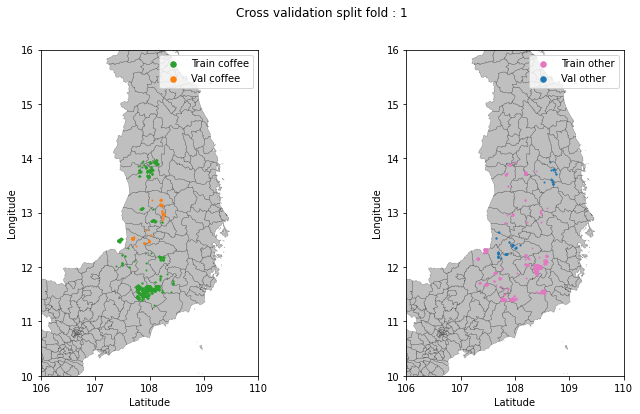

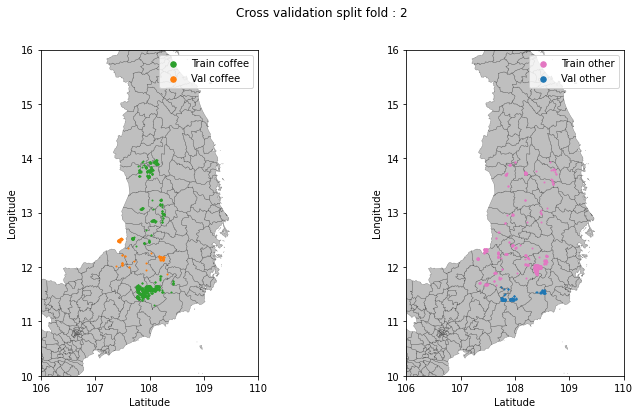

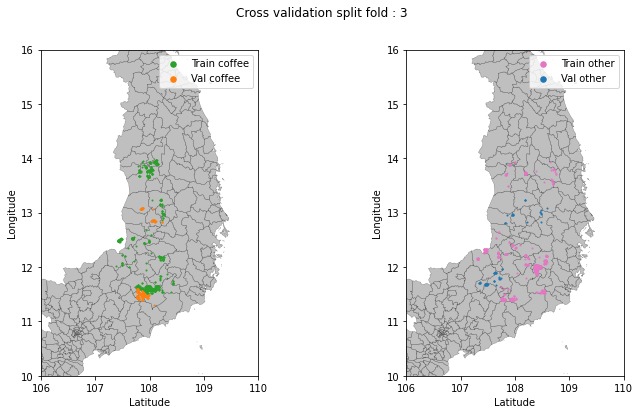

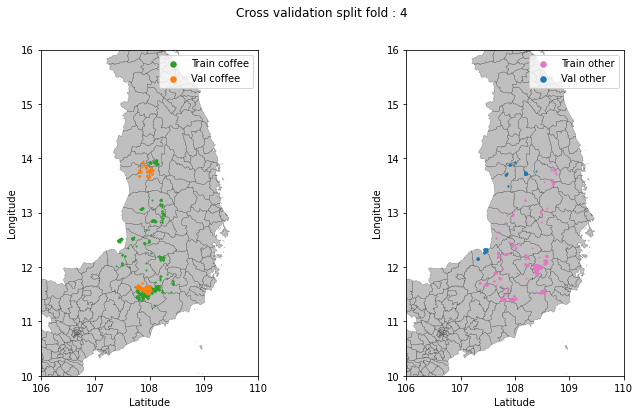

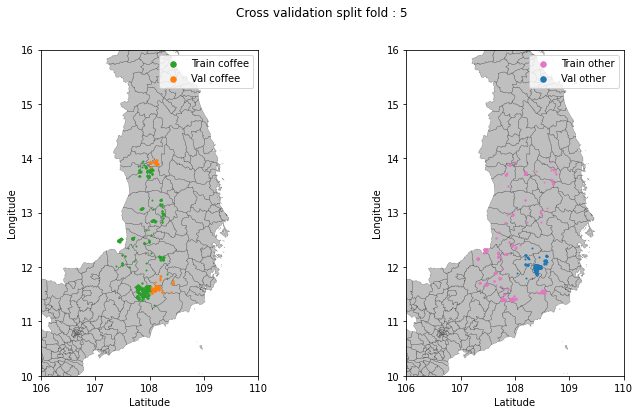

In [11]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_10fold_2",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_10fold_2",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, 
                                geo_val, 
                                vietnam, 
                                f"Cross validation split fold : {i_fold+1}",
                                legend1=["Train culture", "Val culture"],
                                legend2=["Train no-culture", "Val no-culture"])
    
    print(f"Fold {i_fold+1} Number culture - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i_fold+1} Number no-culture - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i_fold+1} Number culture - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-culture - val : {len(geo_val[geo_val['label'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

In [12]:
losses, accs, precisions, recalls, f1_score = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean f1 : {np.mean(f1_score)}")
print(f"Stdev f1 : {np.std(f1_score)}")

Mean accuracy : 0.8140625
Stdev accuracy : 0.05885877563074176


Mean loss : 0.5628271520137786
Stdev loss : 0.12996949792355417


Mean precision : 0.7764490842819214
Stdev precision : 0.09173327683595746


Mean recall : 0.7331345081329346
Stdev recall : 0.13919155114929646


Mean f1 : 0.7396124482154847
Stdev f1 : 0.10077087806600556


In [13]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [30]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_test_32.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

data_test = data_test[data_test['label'].isin(culture_list + no_culture_list)]
data_test.loc[data_test['label'].isin(culture_list), 'label'] = 0
data_test.loc[data_test['label'].isin(no_culture_list), 'label'] =1

In [35]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Culture/spacv_culture32_1/spacv_culture32_1_3.h5"), custom_objects={'LeakyReLU':LeakyReLU})

1/1 [==============================] - 2s 2s/step - loss: 0.6015 - accuracy: 0.8497 - precision: 0.9375 - recall: 0.2830
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       412
           1       0.90      0.25      0.39       107

    accuracy                           0.84       519
   macro avg       0.87      0.62      0.65       519
weighted avg       0.85      0.84      0.80       519

F1-Score : 0.3941605839416058


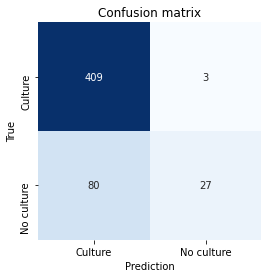

In [36]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=519)
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No culture"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

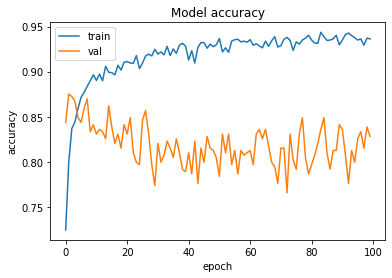

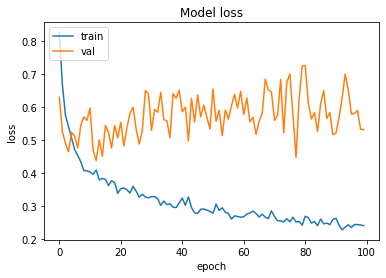

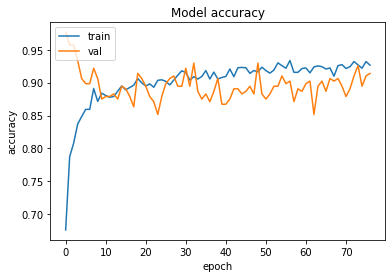

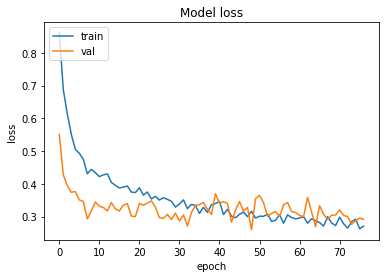

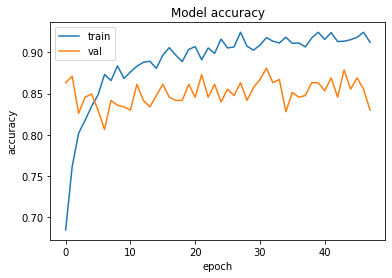

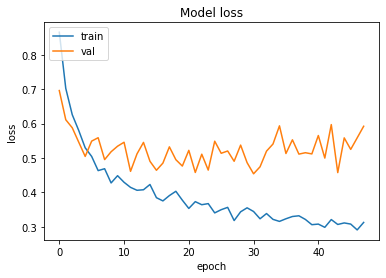

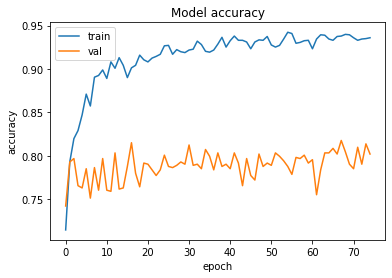

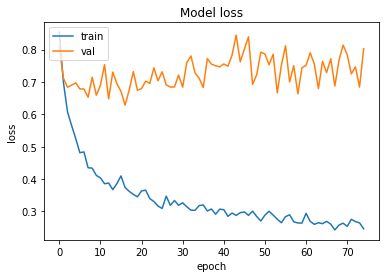

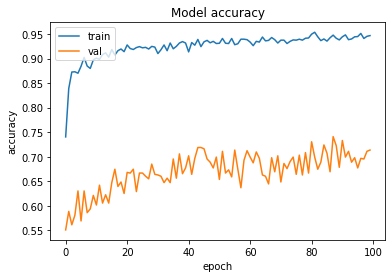

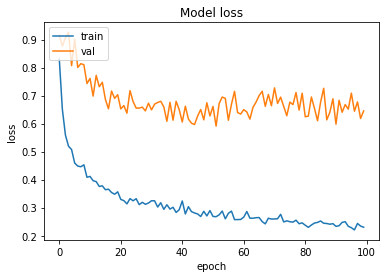

In [5]:
a = os.path.join(SAVED_MODELS_PATH, 'Culture', 'final_spacv_10FOLD_culture_ds2')
for i in os.listdir(a):
    if(i.split('.')[1] == 'npy'):
        chart = np.load(os.path.join(a, i), allow_pickle=True).item()
        
        # summarize history for accuracy
        plt.plot(chart['accuracy'])
        plt.plot(chart['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(chart['loss'])
        plt.plot(chart['val_loss'])
        plt.title('Model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

### Stratified cross-val

In [10]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_spring_train_culture.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

In [11]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'strat_culture_1'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [12]:
from sklearn.model_selection import StratifiedKFold

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1

Epoch 1/100
36/36 [==============================] - 15s 207ms/step - loss: 0.9168 - accuracy: 0.6147 - precision: 0.5715 - recall: 0.7572 - val_loss: 0.6544 - val_accuracy: 0.8438 - val_precision: 0.9822 - val_recall: 0.6831
Epoch 2/100
36/36 [==============================] - 5s 140ms/step - loss: 0.6750 - accuracy: 0.8042 - precision: 0.8781 - recall: 0.6799 - val_loss: 0.5700 - val_accuracy: 0.8457 - val_precision: 0.9465 - val_recall: 0.7195
Epoch 3/100
36/36 [==============================] - 5s 139ms/step - loss: 0.5826 - accuracy: 0.8253 - precision: 0.8821 - recall: 0.7337 - val_loss: 0.5317 - val_accuracy: 0.8496 - val_precision: 0.9583 - val_recall: 0.6970
Epoch 4/100
36/36 [==============================] - 5s 137ms/step - loss: 0.5304 - accuracy: 0.8463 - precision: 0.9062 - recall: 0.7449 - val_loss: 0.4913 - val_accuracy: 0.8691 - val_precision: 0.9561 - val_recall: 0.7717
Epoch 5/100
36/36 [==============================] - 5s 140ms/step - loss: 0.4935 - accuracy: 0.862

36/36 [==============================] - 5s 145ms/step - loss: 0.4696 - accuracy: 0.8465 - precision: 0.8708 - recall: 0.7777 - val_loss: 0.3863 - val_accuracy: 0.8984 - val_precision: 0.9670 - val_recall: 0.8200
Epoch 10/100
36/36 [==============================] - 5s 143ms/step - loss: 0.4299 - accuracy: 0.8675 - precision: 0.9011 - recall: 0.8073 - val_loss: 0.4216 - val_accuracy: 0.8945 - val_precision: 0.9548 - val_recall: 0.7860
Epoch 11/100
36/36 [==============================] - 5s 146ms/step - loss: 0.3934 - accuracy: 0.8938 - precision: 0.9317 - recall: 0.8421 - val_loss: 0.3964 - val_accuracy: 0.8926 - val_precision: 0.9431 - val_recall: 0.8223
Epoch 12/100
36/36 [==============================] - 5s 142ms/step - loss: 0.4338 - accuracy: 0.8701 - precision: 0.8883 - recall: 0.8266 - val_loss: 0.4186 - val_accuracy: 0.8691 - val_precision: 0.9190 - val_recall: 0.7942
Epoch 13/100
36/36 [==============================] - 5s 143ms/step - loss: 0.4366 - accuracy: 0.8766 - preci

36/36 [==============================] - 5s 141ms/step - loss: 0.2772 - accuracy: 0.9272 - precision: 0.9426 - recall: 0.8938 - val_loss: 0.2687 - val_accuracy: 0.9297 - val_precision: 0.9649 - val_recall: 0.8871
Epoch 82/100
36/36 [==============================] - 5s 142ms/step - loss: 0.2630 - accuracy: 0.9224 - precision: 0.9299 - recall: 0.9022 - val_loss: 0.2906 - val_accuracy: 0.9199 - val_precision: 0.9415 - val_recall: 0.8694
Epoch 83/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2618 - accuracy: 0.9316 - precision: 0.9520 - recall: 0.9079 - val_loss: 0.3157 - val_accuracy: 0.9043 - val_precision: 0.9283 - val_recall: 0.8625
Epoch 84/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2722 - accuracy: 0.9262 - precision: 0.9384 - recall: 0.9003 - val_loss: 0.2677 - val_accuracy: 0.9277 - val_precision: 0.9469 - val_recall: 0.9062
Epoch 85/100
36/36 [==============================] - 5s 141ms/step - loss: 0.2490 - accuracy: 0.9340 - preci

36/36 [==============================] - 5s 139ms/step - loss: 0.2902 - accuracy: 0.9174 - precision: 0.9157 - recall: 0.9158 - val_loss: 0.2822 - val_accuracy: 0.9277 - val_precision: 0.9358 - val_recall: 0.8987
Epoch 53/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2853 - accuracy: 0.9309 - precision: 0.9493 - recall: 0.9072 - val_loss: 0.2892 - val_accuracy: 0.9336 - val_precision: 0.9824 - val_recall: 0.8814
Epoch 54/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2851 - accuracy: 0.9288 - precision: 0.9475 - recall: 0.9018 - val_loss: 0.2688 - val_accuracy: 0.9277 - val_precision: 0.9309 - val_recall: 0.9197
Epoch 55/100
36/36 [==============================] - 5s 140ms/step - loss: 0.3079 - accuracy: 0.9168 - precision: 0.9252 - recall: 0.8992 - val_loss: 0.2868 - val_accuracy: 0.9297 - val_precision: 0.9532 - val_recall: 0.8996
Epoch 56/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2937 - accuracy: 0.9213 - preci

36/36 [==============================] - 5s 138ms/step - loss: 0.3123 - accuracy: 0.9228 - precision: 0.9366 - recall: 0.8917 - val_loss: 0.2884 - val_accuracy: 0.9238 - val_precision: 0.8920 - val_recall: 0.9489
Epoch 40/100
36/36 [==============================] - 5s 139ms/step - loss: 0.3126 - accuracy: 0.9136 - precision: 0.9186 - recall: 0.8893 - val_loss: 0.2844 - val_accuracy: 0.9238 - val_precision: 0.9053 - val_recall: 0.9322
Epoch 41/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3312 - accuracy: 0.9072 - precision: 0.9126 - recall: 0.8715 - val_loss: 0.2957 - val_accuracy: 0.9043 - val_precision: 0.8806 - val_recall: 0.9328
Epoch 42/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3357 - accuracy: 0.9020 - precision: 0.9160 - recall: 0.8737 - val_loss: 0.2965 - val_accuracy: 0.9121 - val_precision: 0.8953 - val_recall: 0.9277
Epoch 43/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2912 - accuracy: 0.9337 - preci

36/36 [==============================] - 5s 139ms/step - loss: 0.3460 - accuracy: 0.9218 - precision: 0.9294 - recall: 0.9004 - val_loss: 0.3943 - val_accuracy: 0.8789 - val_precision: 0.8565 - val_recall: 0.8788
Epoch 20/100
36/36 [==============================] - 5s 139ms/step - loss: 0.3682 - accuracy: 0.9040 - precision: 0.9216 - recall: 0.8721 - val_loss: 0.3818 - val_accuracy: 0.8945 - val_precision: 0.9087 - val_recall: 0.8438
Epoch 21/100
36/36 [==============================] - 5s 136ms/step - loss: 0.3671 - accuracy: 0.9006 - precision: 0.9316 - recall: 0.8526 - val_loss: 0.4088 - val_accuracy: 0.8633 - val_precision: 0.8805 - val_recall: 0.8223
Epoch 22/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3573 - accuracy: 0.8968 - precision: 0.9062 - recall: 0.8724 - val_loss: 0.3579 - val_accuracy: 0.9043 - val_precision: 0.9321 - val_recall: 0.8583
Epoch 23/100
36/36 [==============================] - 5s 140ms/step - loss: 0.3321 - accuracy: 0.9195 - preci

36/36 [==============================] - 5s 137ms/step - loss: 0.2469 - accuracy: 0.9387 - precision: 0.9700 - recall: 0.8974 - val_loss: 0.2920 - val_accuracy: 0.9277 - val_precision: 0.9378 - val_recall: 0.9113
Epoch 92/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2522 - accuracy: 0.9351 - precision: 0.9540 - recall: 0.9085 - val_loss: 0.2703 - val_accuracy: 0.9414 - val_precision: 0.9651 - val_recall: 0.9095
Epoch 93/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2580 - accuracy: 0.9243 - precision: 0.9408 - recall: 0.8981 - val_loss: 0.2701 - val_accuracy: 0.9277 - val_precision: 0.9414 - val_recall: 0.9073
Epoch 94/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2492 - accuracy: 0.9342 - precision: 0.9467 - recall: 0.9144 - val_loss: 0.3196 - val_accuracy: 0.9180 - val_precision: 0.9518 - val_recall: 0.8750
Epoch 95/100
36/36 [==============================] - 5s 135ms/step - loss: 0.2556 - accuracy: 0.9324 - preci

In [13]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.9265625
Stdev accuracy : 0.016646309181767592


Mean loss : 0.27794947624206545
Stdev loss : 0.027769519540595488


Mean precision : 0.9395267963409424
Stdev precision : 0.023373058774516606


Mean recall : 0.8953775048255921
Stdev recall : 0.03805134136252921


Mean F1-Score : 0.9162076730067013
Stdev F1-Score : 0.018911896167159256


In [14]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [15]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_spring_test_culture.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

In [16]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Culture/strat_culture_1/strat_culture_1_1.h5"), custom_objects={'LeakyReLU':LeakyReLU})

1/1 [==============================] - 5s 5s/step - loss: 0.2659 - accuracy: 0.9307 - precision: 0.9747 - recall: 0.8750
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       199
           1       0.97      0.88      0.92       176

    accuracy                           0.93       375
   macro avg       0.94      0.93      0.93       375
weighted avg       0.93      0.93      0.93       375

F1-Score : 0.9221556886227545


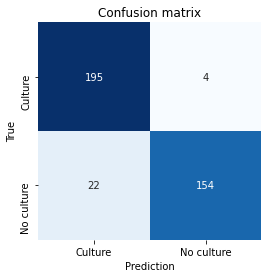

In [17]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No culture"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Model evaluation

In [54]:
restored_model = get_best_cross_val_model(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME), RUN_NAME, results, custom_objects={'LeakyReLU':LeakyReLU})

In [24]:
test_generator = generator(path_test, 
                            y_test, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE)
restored_model.evaluate(test_generator,steps=30)

30/30 [==============================] - 6s 130ms/step - loss: 0.2563 - accuracy: 0.9328


[0.25634971261024475, 0.932812511920929]

In [25]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(model_culture.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

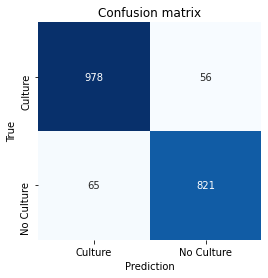

In [27]:
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No Culture"])

In [28]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1034
           1       0.94      0.93      0.93       886

    accuracy                           0.94      1920
   macro avg       0.94      0.94      0.94      1920
weighted avg       0.94      0.94      0.94      1920

F1-Score : 0.9313669880884855


In [33]:
geo_test= gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"test_data.csv")))
geo_test['geometry'] = geo_test['geometry'].apply(wkt.loads)

In [34]:
geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold', 'train_data.csv')))
geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)

In [36]:
a = set(geo_train['path'].to_numpy())
b = set(geo_test['path'].to_numpy())

In [37]:
a.intersection(b)

set()